# Will it be an early Spring?

On February 2<sup>nd</sup> every year Punxsutawney Phil makes a prediction about if there will be an early Spring or if Winter will continue for 6 more weeks (till about mid-March). He is however not very accurate (well, according to [The Inner Circle](https://www.groundhog.org/inner-circle) he is 100% correct but the human handler may not interpret his response correctly). The overall goal is to be able to predict if it will be an early Spring.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled final model along with this notebook.

The group with the best results on the 10% of the data that I kept for myself will earn +5 extra credit (if multiple groups are close points may be given to multiple groups).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Import the RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

Frame the Problem and Look at the Big Picture
========================

1. **Define the objective in business terms.** <mark>The objective is to predict whether there will be an early Spring, allowing farmers to decide whether to purchase a new kind of corn seed that can grow two crops. Early Spring is defined as a period when the average temperature is above 40°F, the minimum temperature is above 32°F, and the average soil temperature is above 50°F before April 1st, with no snow on the ground.</mark>
2. **How will your solution be used?** <mark>The solution will be used by farmers in western PA to make informed decisions about purchasing seeds by February 25th. The prediction will help them determine if conditions will be favorable for planting the new corn seed early.</mark>
3. **What are the current solutions/workarounds (if any)?** <mark>Currently, farmers rely on Punxsutawney Phil's prediction, which is not very accurate. They may also use historical weather data and personal experience to make decisions.</mark>
4. **How should you frame this problem (supervised/unsupervised, online/offline, …)?** <mark>This problem should be framed as a supervised learning problem, where the goal is to predict a binary outcome (early Spring or not) based on historical weather and soil data. This will be a classification model, using offline learning since the most important data involves winter and spring only.</mark>
5. **How should performance be measured? Is the performance measure aligned with the business objective?** <mark>Performance should be measured using accuracy, precision, recall, and F1-score. Since the preference is to avoid false negatives (missing an early Spring), recall might be particularly important.</mark>
6. **What would be the minimum performance needed to reach the business objective?** <mark>The minimum performance needed would be a recall rate that ensures farmers can confidently make purchasing decisions with minimal risk of missing an early Spring.</mark>
7. **What are comparable problems? Can you reuse experience or tools?** <mark>We can use tools from the MNIST in-class notebook to help with this model, especially with working with binary classifiers and a classification model. </mark>
8. **Is human expertise available?** <mark>Yes, human expertise is available from the farmers who have historical data and experience with weather patterns and planting conditions.</mark>
9. **How would you solve the problem manually?** <mark>I would solve this manually by focusing on the weather conditions, soil conditions, temperature of both weather and soil, whether or not there is snow cosverage within the land in Western PA. </mark>
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** <mark>TODO</mark>

Get the Data
=======================================================================

1. **List the data you need and how much you need.** <mark>We need data to predict either an early spring, or late winter. To do that we need weather, soil, and a dataset which gives us a label feature like early spring. Also could use El Nino or La Nina data to predict this.</mark>
2. **Find and document where you can get that data:** <mark>From the client for first 3 datasets. From https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php for El Nino and La Nina data</mark>
3. **Get access authorizations:** <mark>Done</mark>
4. **Create a workspace (with enough storage space)**: This notebook.
5. **Get the data:** <mark>Got the data.</mark>
6. **Convert the data to a format you can easily manipulate (without changing the data itself):** Done, it's a CSV.
7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** Done.
8. **Check the size and type of data (time series, geographical, …):** <mark>TODO</mark> - complete in the cells below
9. **Sample a test set, put it aside, and never look at it (no data snooping!):** <mark>TODO</mark> - complete in the cells below

In [2]:
def load_and_concat_datasets(weather_file, soil_file, output_file='data.csv'):
    # Convert the 'date' in weather and 'day' in soil to datetime for proper merging
    weather_file['date'] = pd.to_datetime(weather_file['date'])
    soil_file['day'] = pd.to_datetime(soil_file['day'])

    # Merge the weather and soil data on 'date' and 'day'
    combined_df = pd.merge(weather_file, soil_file, left_on='date', right_on='day', how='inner')

    # Display the first few rows of the final combined DataFrame
    print(combined_df.head())

    # Save the final combined DataFrame to a CSV file
    combined_df.to_csv(output_file, index=False)

    return combined_df





def read_weather_data(filename):
    """
    Reads weather data from the given file. M values are assumed to be
    missing values (returned as nan). T values are trace values and returned as
    0.0025 inches for precipitation and snowfall and 0.025 inches for snowdepth
    (see https://www.chicagotribune.com/news/weather/ct-wea-asktom-0415-20180413-column.html).
    All temperatures are in Fahrenheit and all precipitation values are in inches.
    """
    def convert_precipitation(raw):
        return 0.0025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    def convert_depth(raw):
        return 0.025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    return pd.read_csv(filename, na_values=['M'], parse_dates=[0],
        converters={
            "precipitation":convert_precipitation,
            "snowfall":convert_precipitation,
            "snowdepth":convert_depth,
        },
        names=["date","max_temp","min_temp","avg_temp","precipitation","snowfall","snowdepth"],
        header=0)

def read_soil_data(filename):
    """
    Reads soil data from the given file.
    All temperatures are in Celsius and all moisture values are in wfv (m^3/m^3).
    """
    return pd.read_csv(filename, parse_dates=[0])




In [3]:
# read csv file
soilData = read_soil_data('soil.csv')
weatherData = read_weather_data('weather.csv')
earlySpring = pd.read_csv('early_spring.csv')

data = load_and_concat_datasets(weatherData, soilData, 'data.csv')

        date  max_temp  min_temp  avg_temp  precipitation  snowfall  \
0 1947-01-01      30.0      24.0      27.0           0.12       0.5   
1 1947-01-02      44.0      29.0      36.5           0.49       0.0   
2 1947-01-03      54.0      41.0      47.5           0.04       0.0   
3 1947-01-04      42.0      24.0      33.0           0.00       0.0   
4 1947-01-05      33.0      25.0      29.0           0.00       0.0   

   snowdepth        day  mean_soil_temp  mean_soil_moisture  min_soil_temp  \
0        1.0 1947-01-01       -3.220000            0.477200           -4.1   
1        0.0 1947-01-02       -2.533333            0.498333           -3.2   
2        NaN 1947-01-03       -1.733333            0.515000           -2.7   
3        NaN 1947-01-04        0.729167            0.496625           -0.1   
4        NaN 1947-01-05        0.162500            0.485792           -0.7   

   min_soil_moisture  max_soil_temp  max_soil_moisture  
0              0.475           -1.4            

In [4]:
# Generate a date range for each year from 1947 to 2024, limited to Jan 1 to Feb 25
date_range = pd.date_range(start='1947-01-01', end='2024-02-25', freq='D')

# Filter to keep only dates from January 1 to February 25 of each year
date_range_filtered = date_range[(date_range.month == 1) | ((date_range.month == 2) & (date_range.day <= 25))]

# Remove values from data that are not in date range
data = data[data['date'].isin(date_range_filtered)]

# Filter the date range to only include January and February (Jan 1 to Feb 25)
january_february_range = date_range_filtered

# Find any missing dates in the 'date' column
missing_dates = january_february_range[~january_february_range.isin(data['date'])]

# Display the missing dates
missing_dates

DatetimeIndex(['1958-01-01', '1958-01-02', '1958-01-03', '1958-01-04',
               '1958-01-05', '1958-01-06', '1958-01-07', '1958-01-08',
               '1958-01-09', '1958-01-10',
               ...
               '2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23',
               '2019-02-24', '2019-02-25'],
              dtype='datetime64[ns]', length=448, freq=None)

In [5]:
# Create a DataFrame for the missing dates
missing_dates_df = pd.DataFrame({'date': missing_dates})

# Combine the original data with the missing dates
combined_data = pd.concat([data, missing_dates_df])

#Sort the combined data by date
data = combined_data.sort_values(by='date').reset_index(drop=True)


In [6]:
#show every column
pd.set_option('display.max_columns', None)
dat = data.copy()
dat['year'] = dat.date.dt.year
dat['day_of_year'] = dat.date.dt.dayofyear
dat = dat.drop(columns=['date']).pivot(index='year', columns='day_of_year')
dat.columns = ["_".join([str(x) for x in a]) for a in dat.columns.to_flat_index()]

In [7]:
#set index of earlySpring to year
earlySpring = earlySpring.sort_values(by='year').reset_index(drop=True)

# Create a DataFrame with all years from the minimum to the maximum year
all_years = pd.DataFrame({'year': range(earlySpring['year'].min(), earlySpring['year'].max() + 1)})

# Merge with the original DataFrame
merged_earlySpring = pd.merge(all_years, earlySpring, on='year', how='left')

# Fill NaN for early_spring where data is not available
merged_earlySpring['early_spring'] = merged_earlySpring['early_spring'].fillna(np.nan)



In [8]:
earlySpring = merged_earlySpring.set_index('year')

In [9]:
data = dat.join(earlySpring, how='inner')

In [10]:
# read ExtraDataONI.csv
oni_data = pd.read_csv('ExtraDataONI.csv')

oni_data = oni_data.set_index('year')
oni_data
# merge data with oni_data
data = data.join(oni_data, how='inner')

In [11]:
# If there are categorical columns, list their unique values and counts
for col in data.select_dtypes(include=['object']).columns:
    print(f"Unique values for {col}:")
    print(data[col].value_counts())

Unique values for early_spring:
early_spring
False    35
True     35
Name: count, dtype: int64


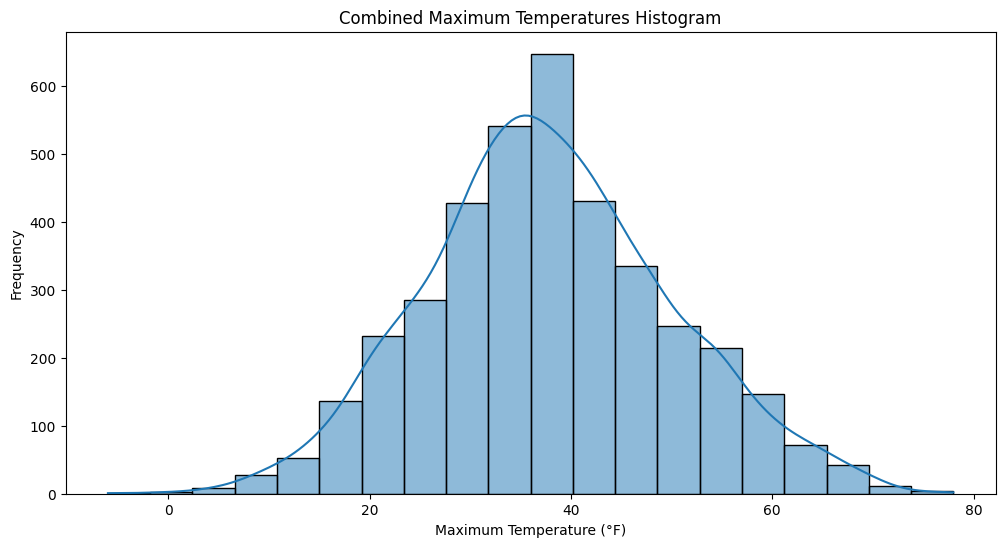

In [12]:
max_temp_values = pd.melt(data, value_vars=[col for col in data if 'max_temp' in col], 
                           var_name='Temperature_Type', value_name='Max_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_temp_values['Max_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Maximum Temperatures Histogram')
plt.xlabel('Maximum Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

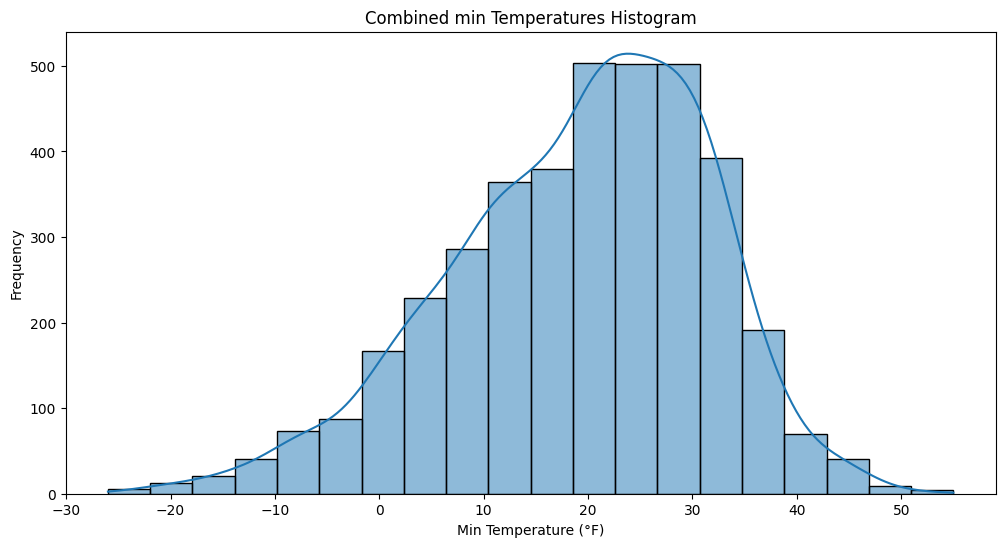

In [13]:
min_temp_values = pd.melt(data, value_vars=[col for col in data if 'min_temp' in col], 
                           var_name='Temperature_Type', value_name='Min_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_temp_values['Min_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined min Temperatures Histogram')
plt.xlabel('Min Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

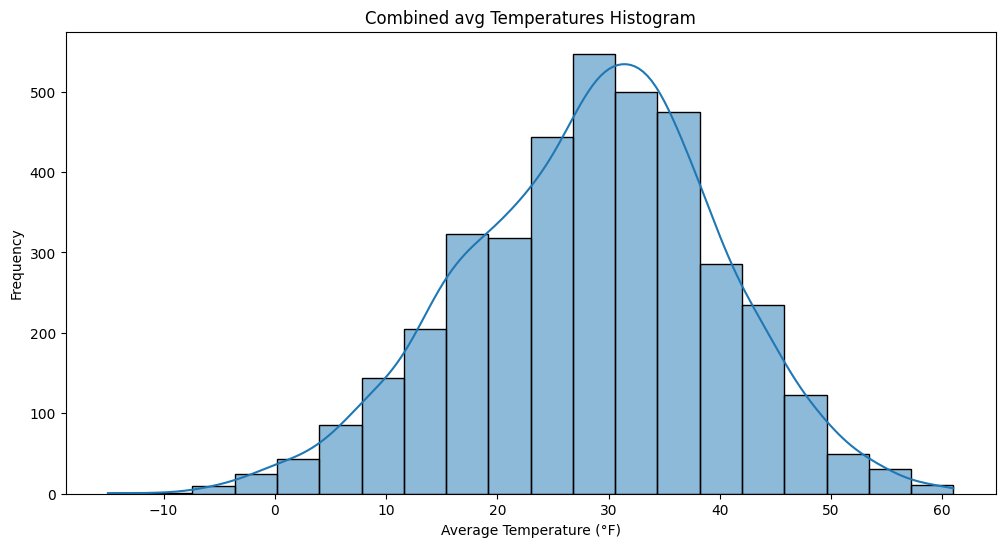

In [14]:
avg_temp_values = pd.melt(data, value_vars=[col for col in data if 'avg_temp' in col], 
                           var_name='Temperature_Type', value_name='Avg_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(avg_temp_values['Avg_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined avg Temperatures Histogram')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

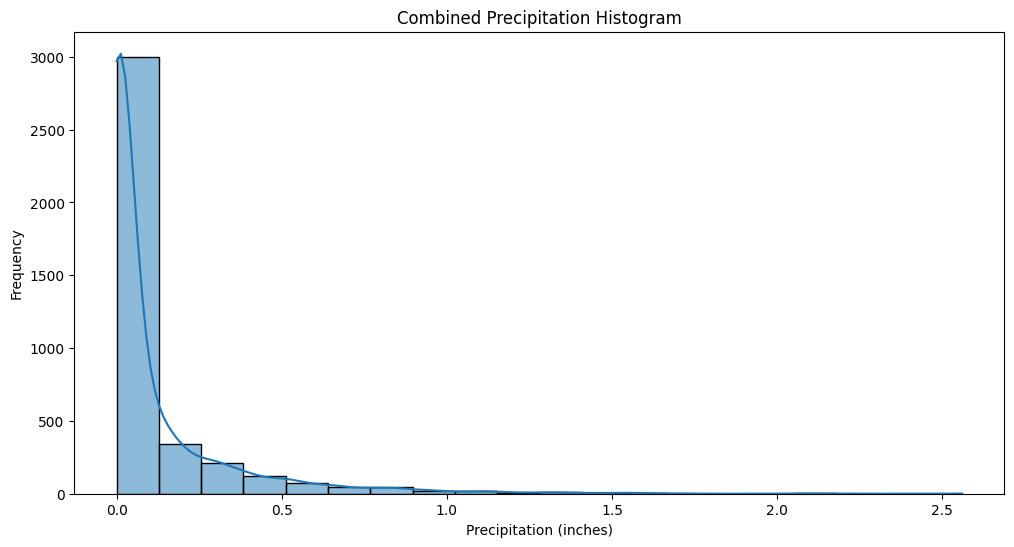

In [15]:
precipitation_values = pd.melt(data, value_vars=[col for col in data if 'precipitation' in col],
                                 var_name='Precipitation_Type', value_name='Precipitation')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(precipitation_values['Precipitation'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Precipitation Histogram')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

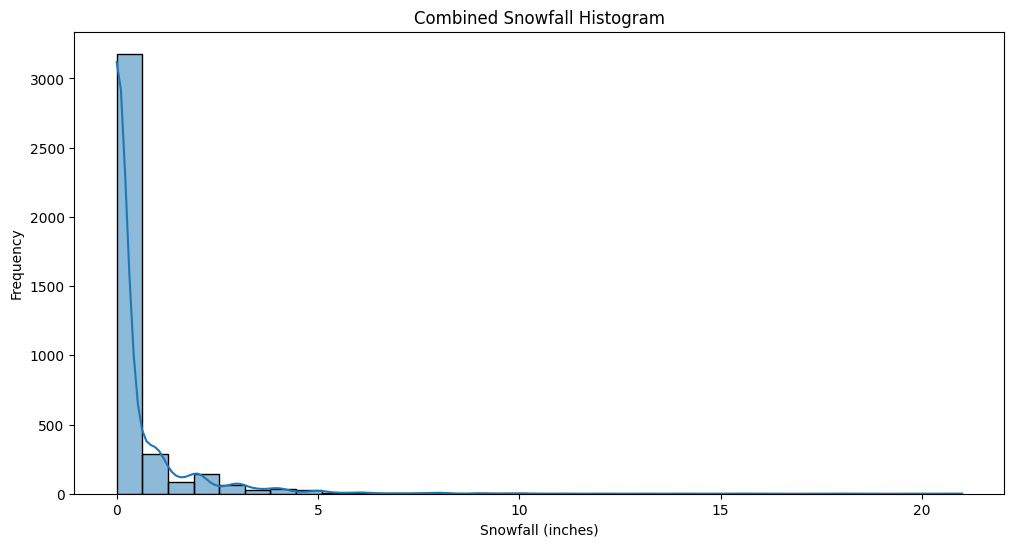

In [16]:
snowfall_values = pd.melt(data, value_vars=[col for col in data if 'snowfall' in col],
                                    var_name='Snowfall_Type', value_name='Snowfall')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(snowfall_values['Snowfall'], bins=33, kde=True)

# Add labels and title
plt.title('Combined Snowfall Histogram')
plt.xlabel('Snowfall (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

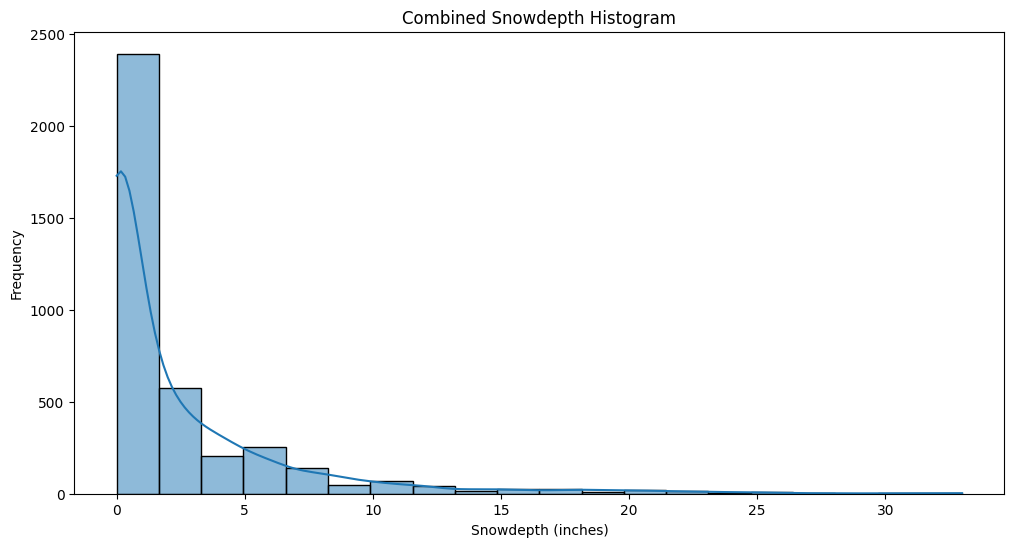

In [17]:
snowdepth_values = pd.melt(data, value_vars=[col for col in data if 'snowdepth' in col],
                                    var_name='Snowdepth_Type', value_name='Snowdepth')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(snowdepth_values['Snowdepth'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Snowdepth Histogram')
plt.xlabel('Snowdepth (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

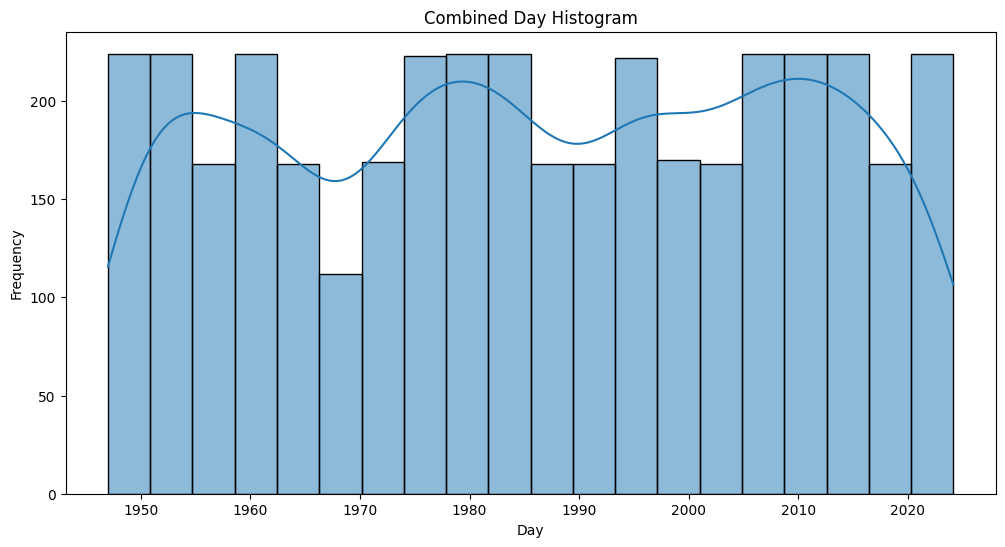

In [18]:
day_values = pd.melt(data, value_vars=[col for col in data if 'day' in col],
                                    var_name='Day_Type', value_name='Day')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(day_values['Day'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Day Histogram')
plt.xlabel('Day')
plt.ylabel('Frequency')

# Show the plot
plt.show()

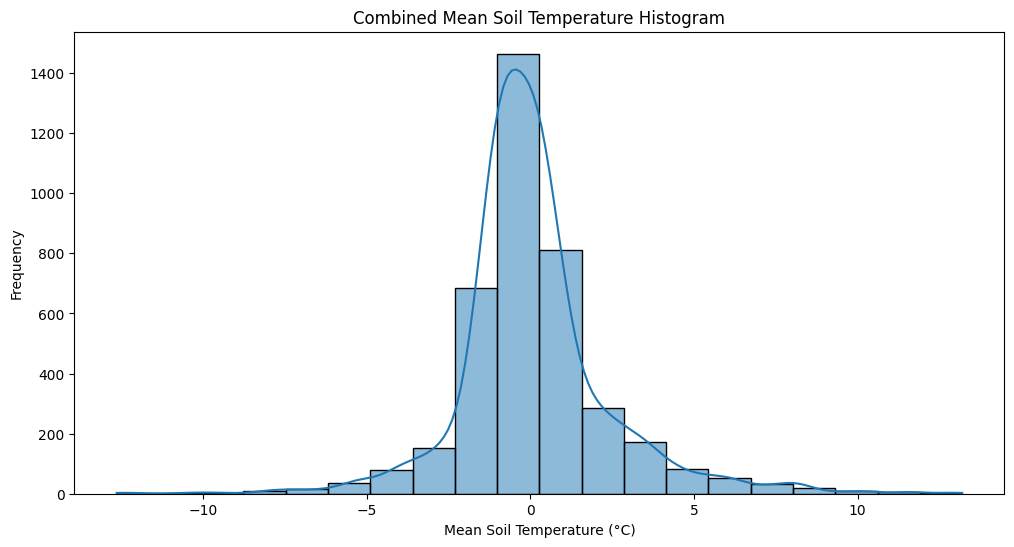

In [19]:
mean_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'mean_soil_temp' in col],
                                    var_name='Mean_Soil_Temperature_Type', value_name='Mean_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(mean_soil_temp_values['Mean_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Mean Soil Temperature Histogram')
plt.xlabel('Mean Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

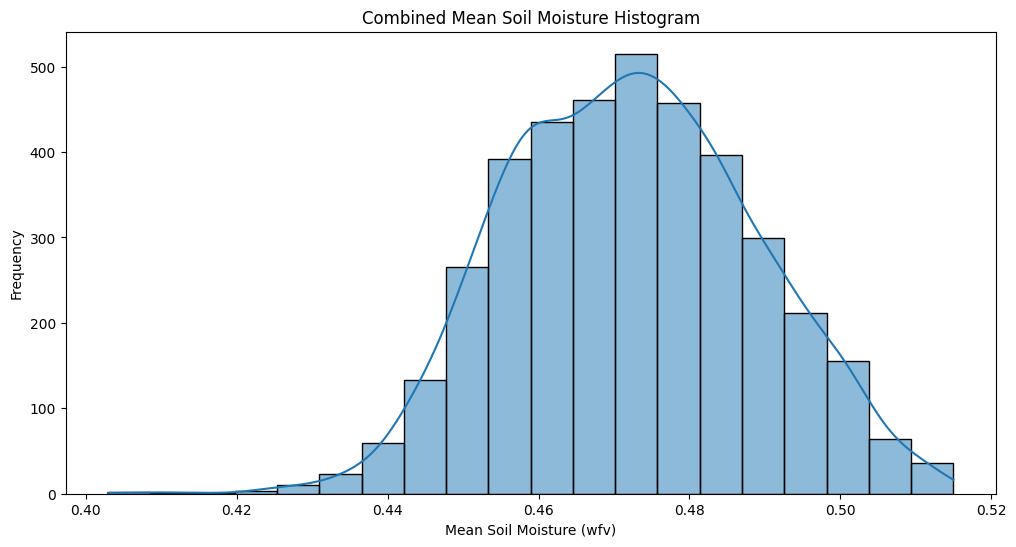

In [20]:
mean_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'mean_soil_moisture' in col],
                                    var_name='Mean_Soil_Moisture_Type', value_name='Mean_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(mean_soil_moisture_values['Mean_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Mean Soil Moisture Histogram')
plt.xlabel('Mean Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

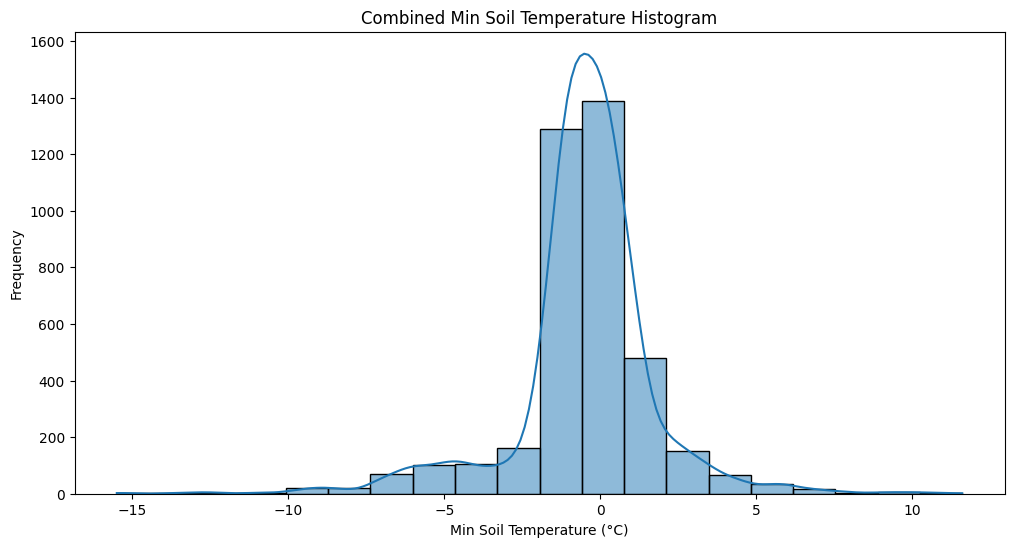

In [21]:
min_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'min_soil_temp' in col],
                                    var_name='Min_Soil_Temperature_Type', value_name='Min_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_soil_temp_values['Min_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Min Soil Temperature Histogram')
plt.xlabel('Min Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

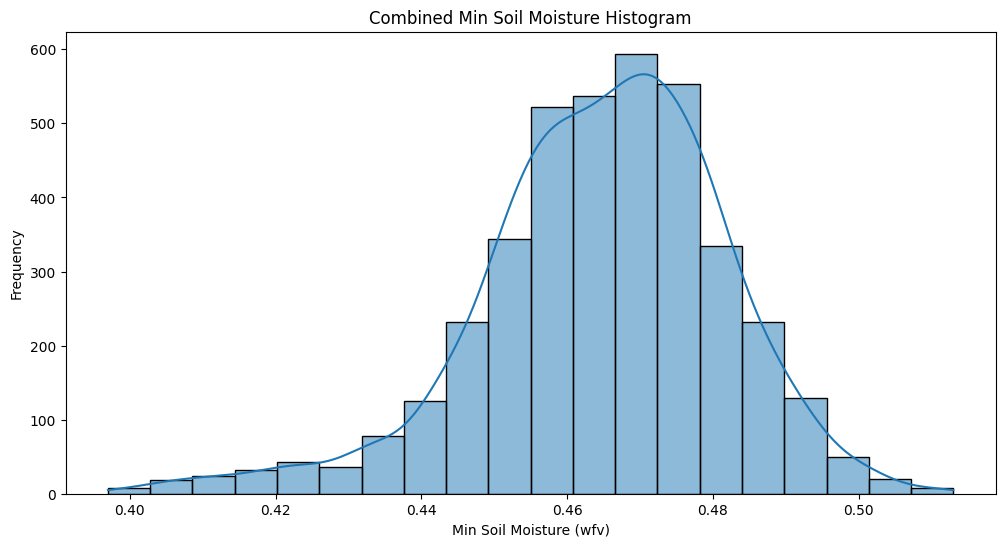

In [22]:
min_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'min_soil_moisture' in col],
                                    var_name='Min_Soil_Moisture_Type', value_name='Min_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_soil_moisture_values['Min_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Min Soil Moisture Histogram')
plt.xlabel('Min Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


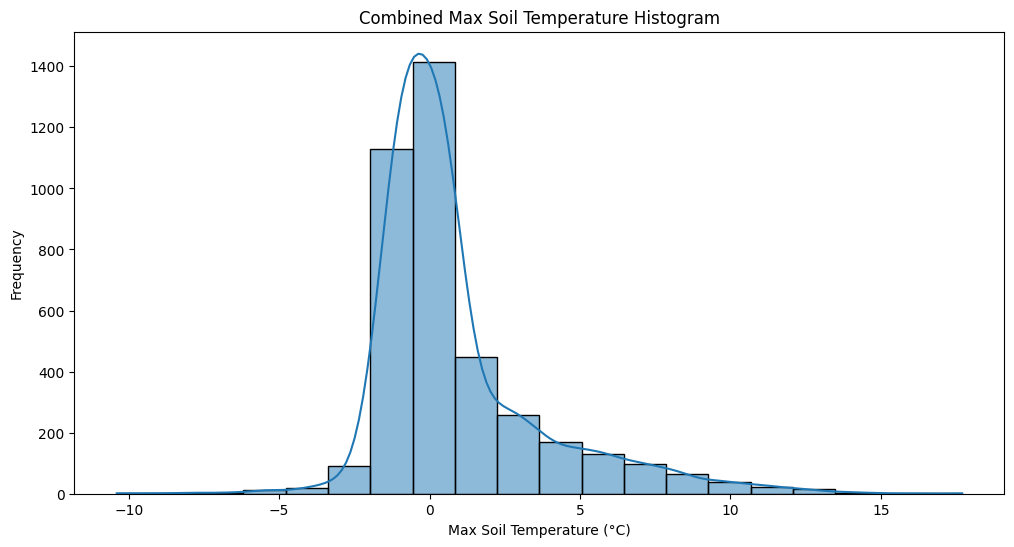

In [23]:
max_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'max_soil_temp' in col],
                                    var_name='Max_Soil_Temperature_Type', value_name='Max_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_soil_temp_values['Max_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Max Soil Temperature Histogram')
plt.xlabel('Max Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


### Splitting Data

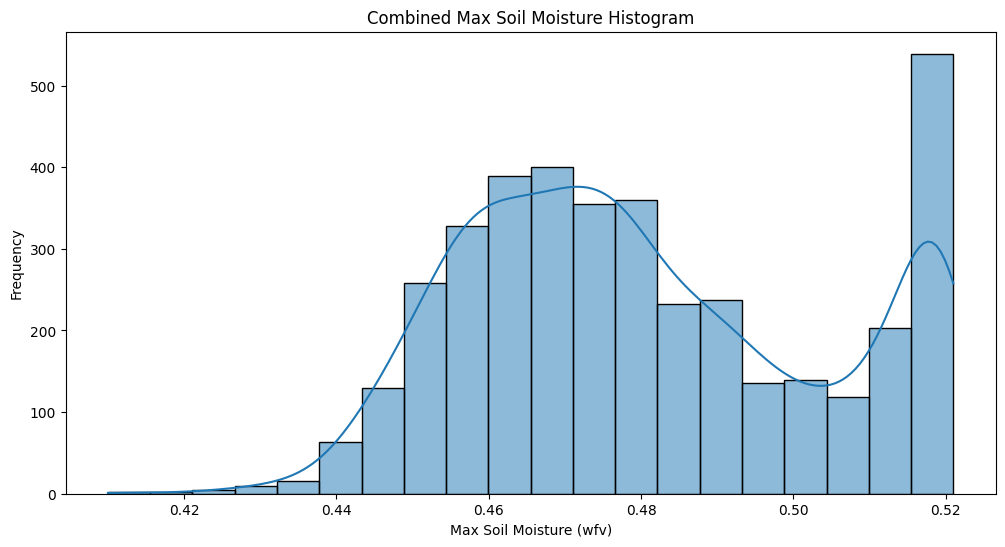

In [24]:
max_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'max_soil_moisture' in col],
                                    var_name='Max_Soil_Moisture_Type', value_name='Max_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_soil_moisture_values['Max_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Max Soil Moisture Histogram')
plt.xlabel('Max Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

<Axes: xlabel='DJF', ylabel='Count'>

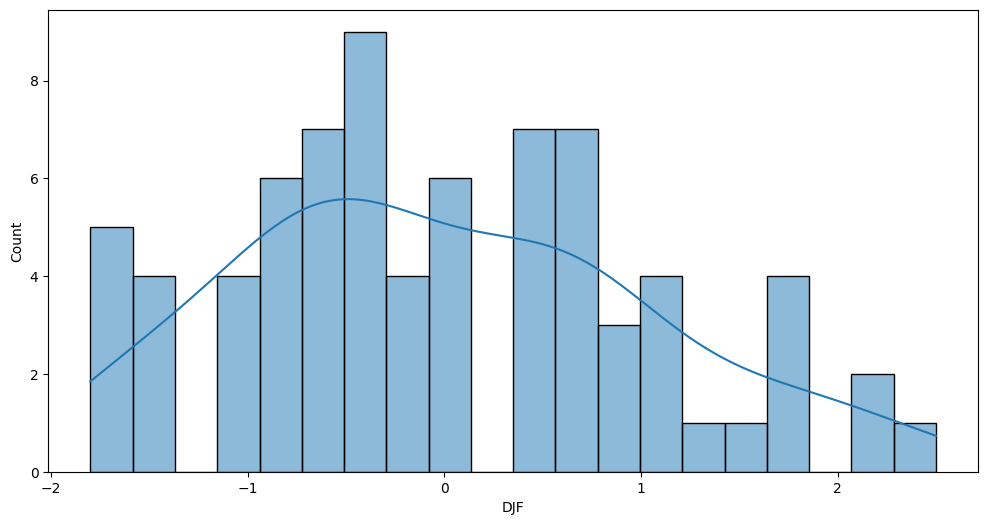

In [25]:
#plot DJF variable in data

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['DJF'], bins=20, kde=True)

<Axes: xlabel='JFM', ylabel='Count'>

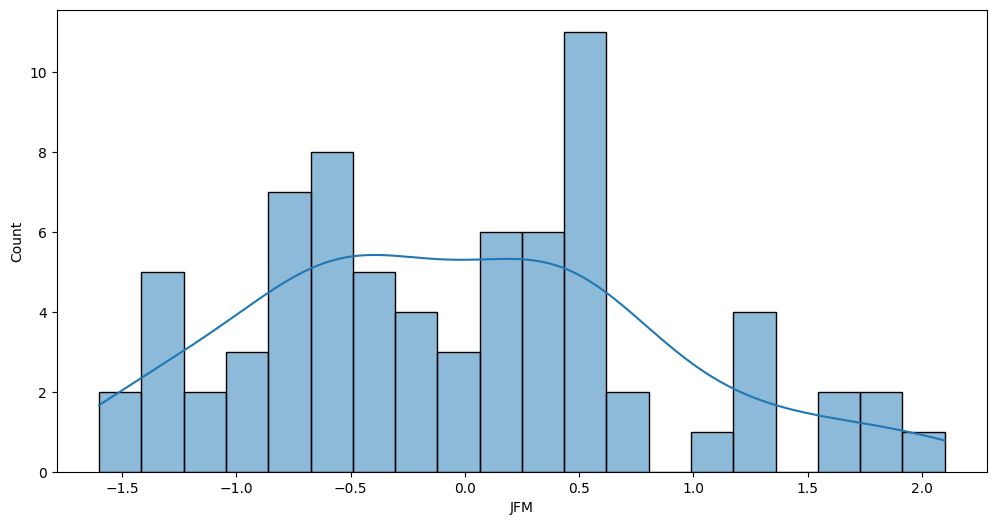

In [26]:
#plot JFM
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['JFM'], bins=20, kde=True)

<Axes: xlabel='FMA', ylabel='Count'>

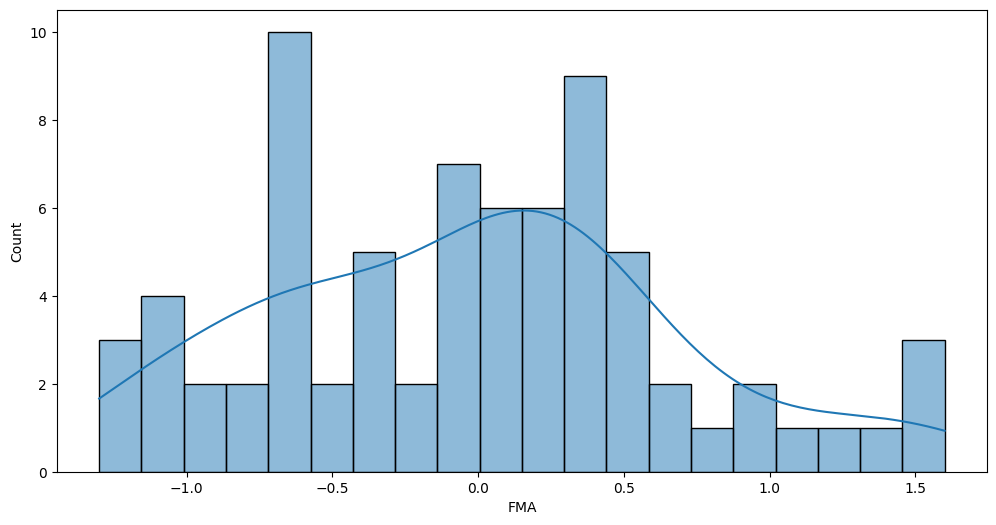

In [27]:
#plot FMA

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['FMA'], bins=20, kde=True)

<Axes: xlabel='MAM', ylabel='Count'>

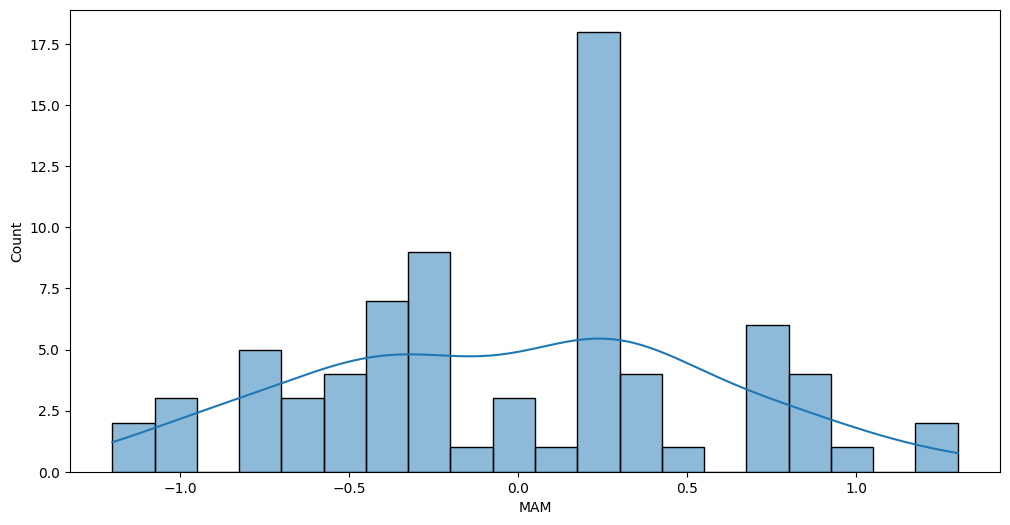

In [28]:
#plot MAM

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['MAM'], bins=20, kde=True)

<Axes: xlabel='AMJ', ylabel='Count'>

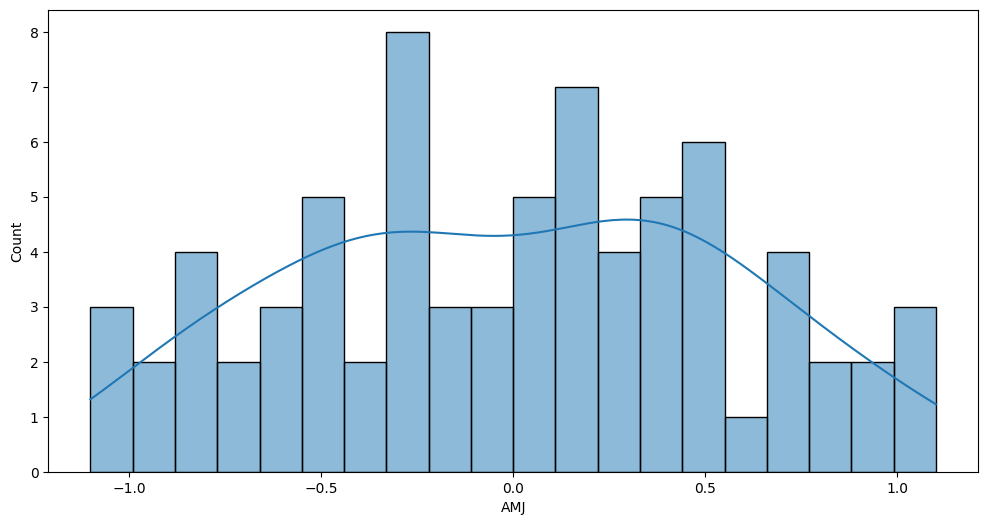

In [29]:
#plot AMJ

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['AMJ'], bins=20, kde=True)

<Axes: xlabel='MJJ', ylabel='Count'>

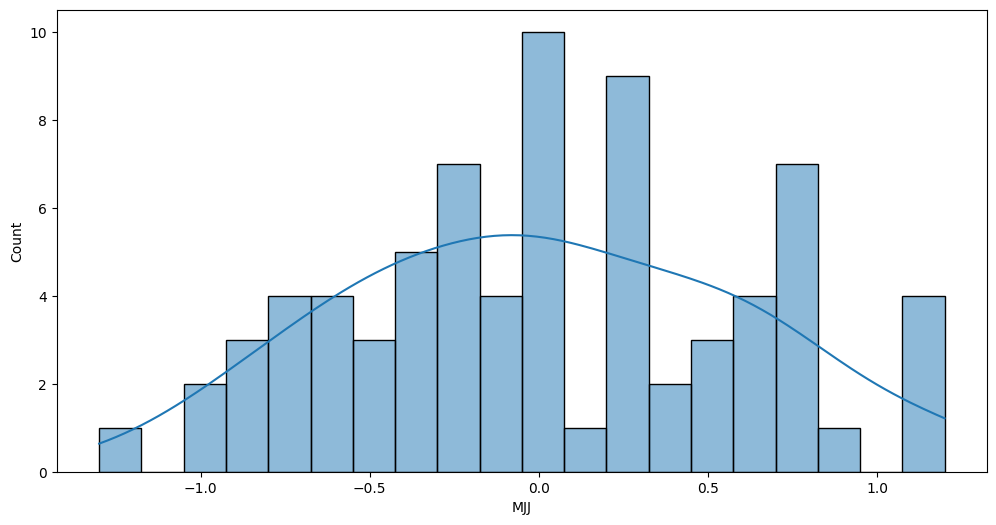

In [30]:
#plot MJJ

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['MJJ'], bins=20, kde=True)

<Axes: xlabel='JJA', ylabel='Count'>

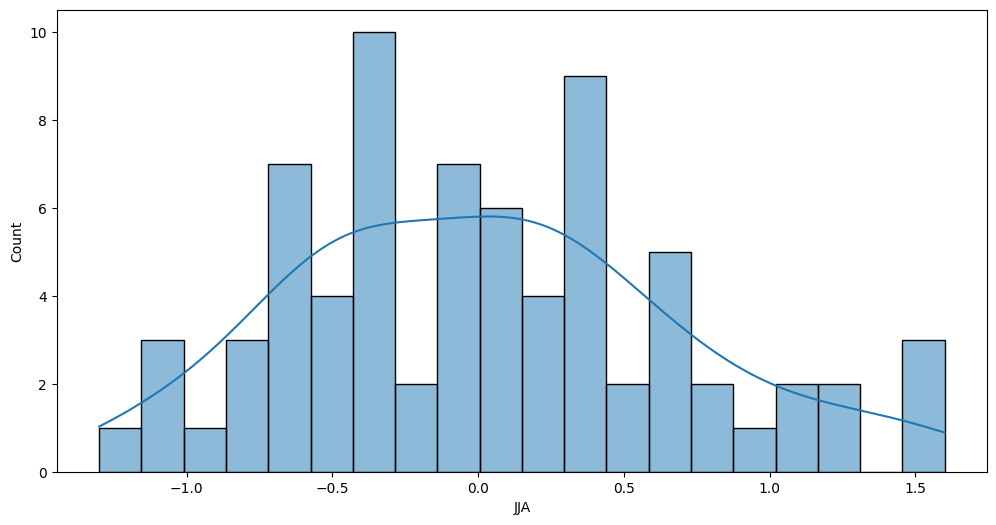

In [31]:
#plot JJA

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['JJA'], bins=20, kde=True)

<Axes: xlabel='JAS', ylabel='Count'>

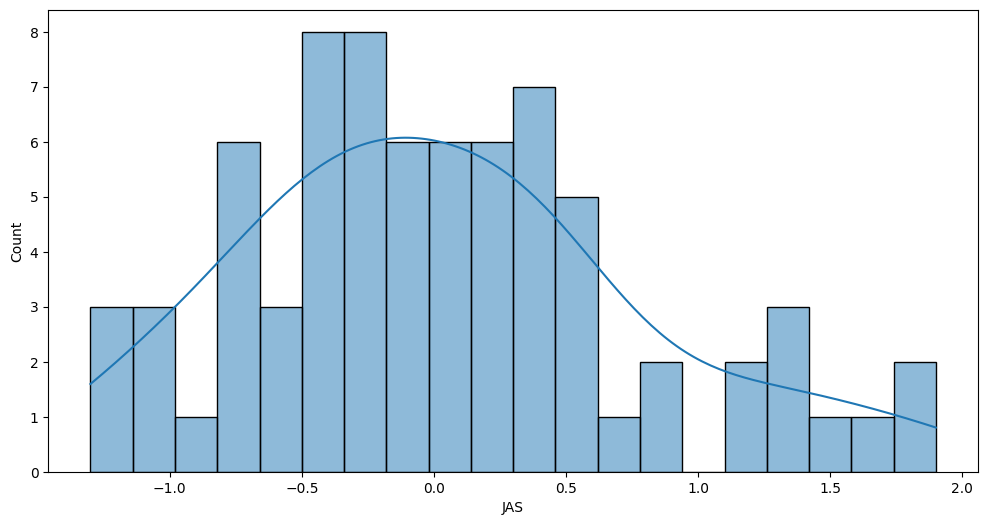

In [32]:
#plot JAS

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['JAS'], bins=20, kde=True)

<Axes: xlabel='ASO', ylabel='Count'>

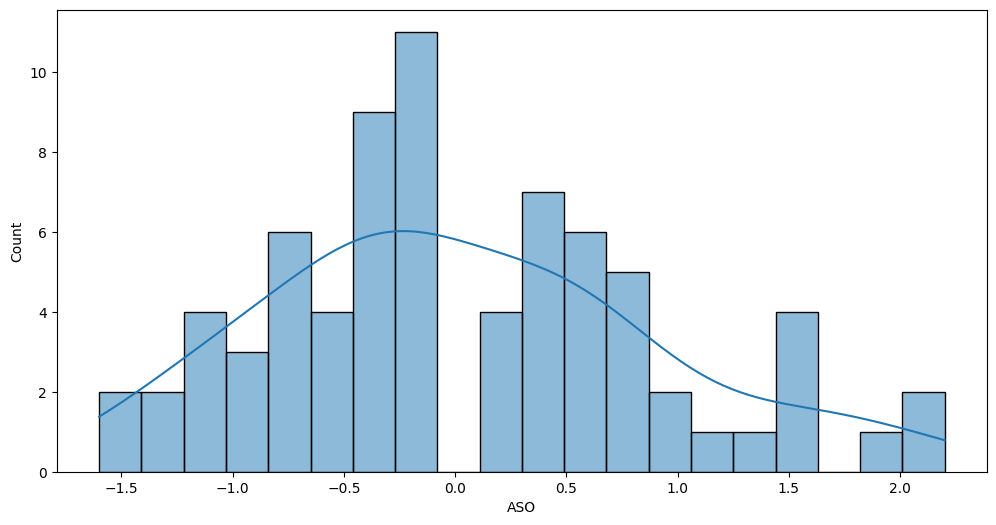

In [33]:
#plot ASO

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['ASO'], bins=20, kde=True)

<Axes: xlabel='SON', ylabel='Count'>

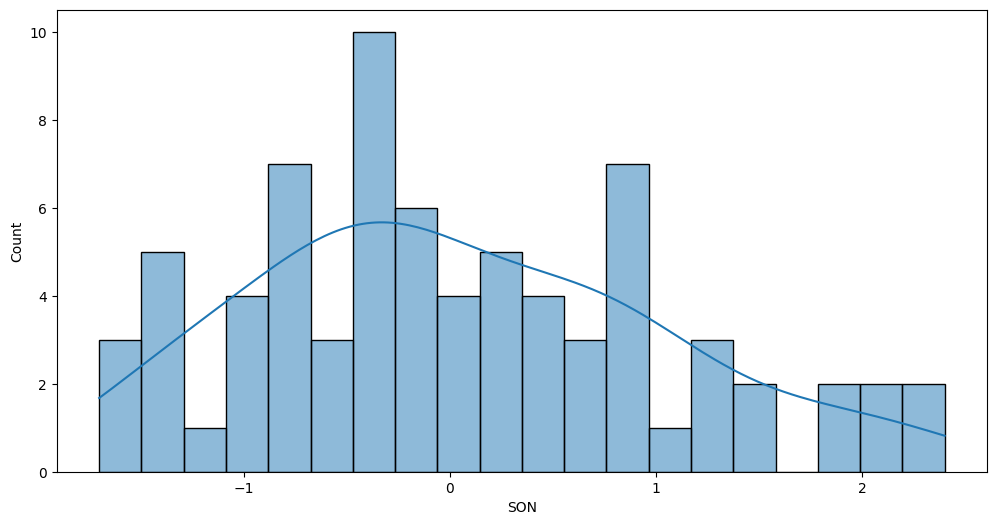

In [34]:
#plot SON

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['SON'], bins=20, kde=True)

<Axes: xlabel='OND', ylabel='Count'>

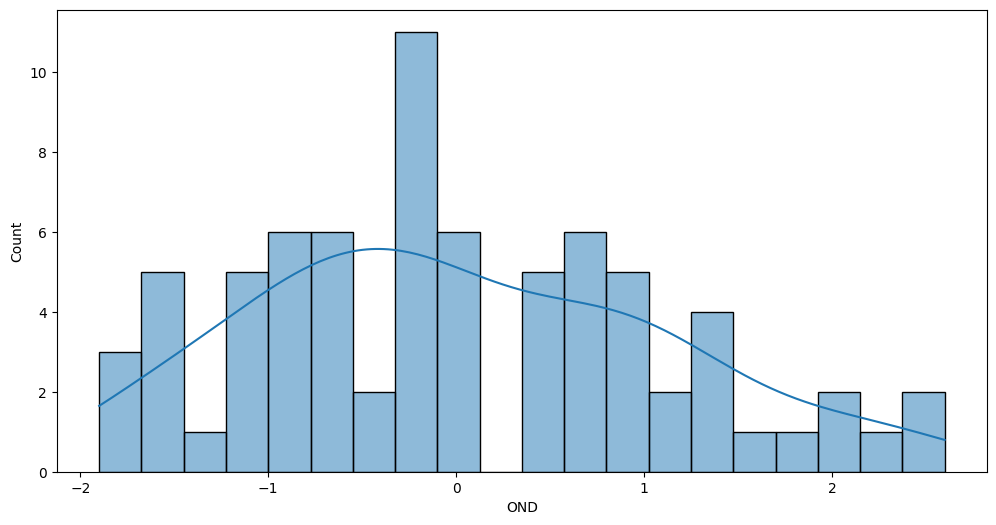

In [35]:
#plot OND

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['OND'], bins=20, kde=True)

<Axes: xlabel='NDJ', ylabel='Count'>

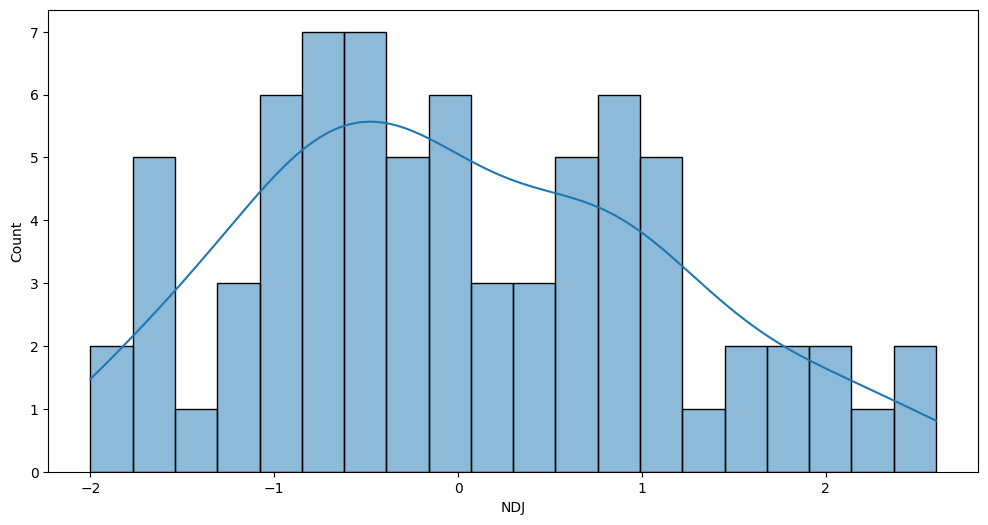

In [36]:
#plot NDJ

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['NDJ'], bins=20, kde=True)

<Axes: xlabel='early_spring', ylabel='Count'>

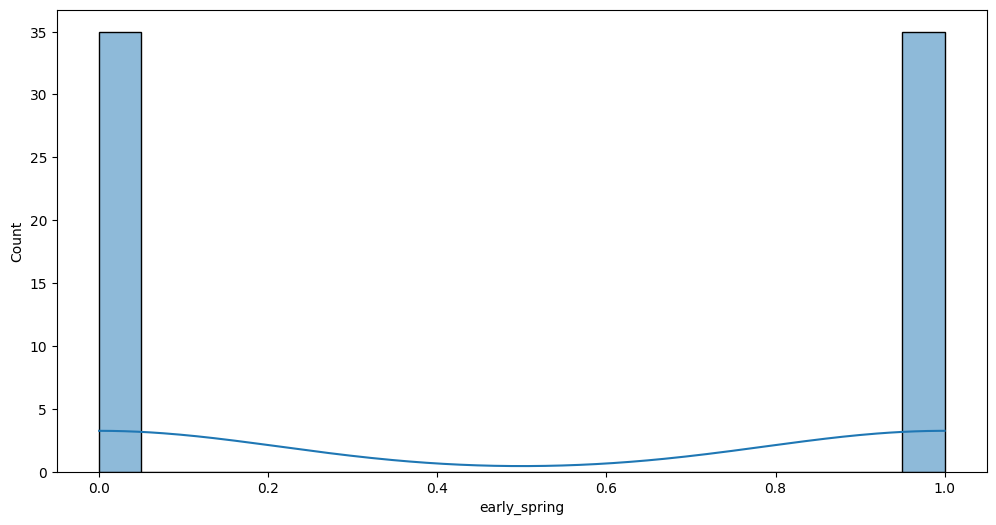

In [37]:
#early_spring

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['early_spring'], bins=20, kde=True)

In [38]:
#code to check which values of early spring are NAN
data[data['early_spring'].isnull()]

#drop rows with NAN values
data = data.dropna(subset=['early_spring'])

data['early_spring'].value_counts()

early_spring
False    35
True     35
Name: count, dtype: int64

In [39]:
from sklearn.model_selection import train_test_split

# Perform the train-test split on the filtered data stratifying early_spring
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data['early_spring'])

## Get the Data Notes

- Took 10% for test because of small data size
- Filled NAN values of early_spring with unknown and converted true and false to strings so I could stratify. 

Things I'm interested in for data visualizaion
- Do different days have more or less of an effect on whether its an early spring or not?

# Explore the Data

In [40]:
#drop any column with day in it
train_data = train_data.drop(columns=[col for col in train_data if 'day' in col])

# make early_spring (True if its an early spring False if its not) 1 if its an early spring and 0 if its not an early spring
train_data['early_spring'] = train_data['early_spring'].astype(int)


In [41]:


train_data['early_spring'].value_counts()

early_spring
1    32
0    31
Name: count, dtype: int64

In [42]:

# Create the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(train_data.drop(columns=['early_spring']), train_data['early_spring'])

# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Create a DataFrame from the feature importances
feature_importances_df = pd.DataFrame({
    'feature': train_data.drop(columns=['early_spring']).columns,
    'importance': feature_importances
})

# Sort values by importance
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

feature_importances_df

,feature,importance
371,mean_soil_temp_36,0.013644
52,max_temp_53,0.011507
388,mean_soil_temp_53,0.011100
282,snowdepth_3,0.010803
539,min_soil_moisture_36,0.009819
...,...,...
366,mean_soil_temp_31,0.000000
99,min_temp_44,0.000000
100,min_temp_45,0.000000
101,min_temp_46,0.000000


In [43]:
# Max Soil Temperature
max_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'max_soil_temp' in col],
                               var_name='Max_Soil_Temperature_Type', value_name='Max_Soil_Temperature')

# Min Soil Temperature
min_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'min_soil_temp' in col],
                               var_name='Min_Soil_Temperature_Type', value_name='Min_Soil_Temperature')

# Average Soil Temperature
avg_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'avg_soil_temp' in col],
                               var_name='Avg_Soil_Temperature_Type', value_name='Avg_Soil_Temperature')

# Max Temperature
max_temp_values = pd.melt(data, value_vars=[col for col in data if 'max_temp' in col],
                          var_name='Max_Temperature_Type', value_name='Max_Temperature')

# Min Temperature
min_temp_values = pd.melt(data, value_vars=[col for col in data if 'min_temp' in col],
                          var_name='Min_Temperature_Type', value_name='Min_Temperature')

# Average Temperature
avg_temp_values = pd.melt(data, value_vars=[col for col in data if 'avg_temp' in col],
                          var_name='Avg_Temperature_Type', value_name='Avg_Temperature')

# Precipitation
precipitation_values = pd.melt(data, value_vars=[col for col in data if 'precipitation' in col],
                               var_name='Precipitation_Type', value_name='Precipitation')

# Snowfall
snowfall_values = pd.melt(data, value_vars=[col for col in data if 'snowfall' in col],
                          var_name='Snowfall_Type', value_name='Snowfall')

# Snow Depth
snowdepth_values = pd.melt(data, value_vars=[col for col in data if 'snowdepth' in col],
                           var_name='Snowdepth_Type', value_name='Snowdepth')

# Mean Soil Moisture
mean_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'mean_soil_moisture' in col],
                                    var_name='Mean_Soil_Moisture_Type', value_name='Mean_Soil_Moisture')

# Max Soil Moisture
max_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'max_soil_moisture' in col],
                                   var_name='Max_Soil_Moisture_Type', value_name='Max_Soil_Moisture')

# Min Soil Moisture
min_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'min_soil_moisture' in col],
                                   var_name='Min_Soil_Moisture_Type', value_name='Min_Soil_Moisture')

# Mean Soil Temperature
mean_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'mean_soil_temp' in col],
                                var_name='Mean_Soil_Temperature_Type', value_name='Mean_Soil_Temperature')



In [44]:
def combine_data(max_soil_temp_values, min_soil_temp_values, avg_soil_temp_values,
                 max_temp_values, min_temp_values, avg_temp_values,
                 precipitation_values, snowfall_values, snowdepth_values,
                 mean_soil_moisture_values, max_soil_moisture_values, min_soil_moisture_values,
                 mean_soil_temp_values,
                 train_data):
    """
    Combines the given DataFrames into a single DataFrame with the following columns:
    - Max_Soil_Temperature
    - Min_Soil_Temperature
    - Avg_Soil_Temperature
    - Max_Temperature
    - Min_Temperature
    - Avg_Temperature
    - Precipitation
    - Snowfall
    - Snowdepth
    - Mean_Soil_Moisture
    - Max_Soil_Moisture
    - Min_Soil_Moisture
    - early_spring
    """

    combined_data = pd.merge(max_soil_temp_values[['Max_Soil_Temperature']],
                             min_soil_temp_values[['Min_Soil_Temperature']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             avg_soil_temp_values[['Avg_Soil_Temperature']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             max_temp_values[['Max_Temperature']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             min_temp_values[['Min_Temperature']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             avg_temp_values[['Avg_Temperature']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             precipitation_values[['Precipitation']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             snowfall_values[['Snowfall']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             snowdepth_values[['Snowdepth']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             mean_soil_moisture_values[['Mean_Soil_Moisture']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             max_soil_moisture_values[['Max_Soil_Moisture']],
                             left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             min_soil_moisture_values[['Min_Soil_Moisture']],
                             left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                            mean_soil_temp_values[['Mean_Soil_Temperature']],
                            left_index=True, right_index=True)

    combined_data = pd.merge(combined_data,
                             train_data[['early_spring']],
                             left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                             train_data[['DJF']],
                             left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['JFM']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['FMA']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['MAM']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['AMJ']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['MJJ']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['JJA']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['JAS']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['ASO']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['SON']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['OND']],
                                left_index=True, right_index=True)
    
    combined_data = pd.merge(combined_data,
                                train_data[['NDJ']],
                                left_index=True, right_index=True)

    combined_data.columns = ['Max_Soil_Temperature', 'Min_Soil_Temperature', 'Avg_Soil_Temperature',
                             'Max_Temperature', 'Min_Temperature', 'Avg_Temperature', 'Precipitation',
                             'Snowfall', 'Snowdepth', 'Mean_Soil_Moisture', 'Max_Soil_Moisture',
                             'Min_Soil_Moisture', 'Mean_Soil_Temp', 'early_spring', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    
    return combined_data

combined_data = combine_data(max_soil_temp_values, min_soil_temp_values, avg_soil_temp_values,
                             max_temp_values, min_temp_values, avg_temp_values,
                             precipitation_values, snowfall_values, snowdepth_values,
                             mean_soil_moisture_values, max_soil_moisture_values, min_soil_moisture_values, mean_soil_temp_values,
                             train_data)

combined_data.columns = ['Max_Soil_Temperature', 'Min_Soil_Temperature', 'Avg_Soil_Temperature',
                         'Max_Temperature', 'Min_Temperature', 'Avg_Temperature', 'Precipitation',
                         'Snowfall', 'Snowdepth', 'Mean_Soil_Moisture', 'Max_Soil_Moisture',
                         'Min_Soil_Moisture', 'Mean_Soil_Temp', 'early_spring', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']


In [45]:
combined_data

,Max_Soil_Temperature,Min_Soil_Temperature,Avg_Soil_Temperature,Max_Temperature,Min_Temperature,Avg_Temperature,Precipitation,Snowfall,Snowdepth,Mean_Soil_Moisture,Max_Soil_Moisture,Min_Soil_Moisture,Mean_Soil_Temp,early_spring,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
1947,-1.2,-1.2,28.0,28.0,21.0,24.5,0.0500,1.0000,4.000,0.459708,0.460,0.459,-1.200000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948,1.2,0.6,54.0,54.0,29.0,41.5,0.1400,0.0000,0.000,0.483875,0.487,0.480,0.837500,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,-0.3,-0.8,36.0,36.0,9.0,22.5,0.2400,0.0025,3.000,0.473917,0.520,0.460,-0.637500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,-6.5,-13.4,31.0,31.0,-9.0,11.0,0.0400,1.0000,4.000,0.468000,0.468,0.468,-10.425000,0,-1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951,-1.2,-1.3,23.0,23.0,0.0,11.5,0.0500,1.0000,9.000,0.466625,0.468,0.466,-1.266667,0,-0.8,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,-9.4,-15.3,7.0,7.0,-13.0,-3.0,0.0000,0.0000,3.000,0.468000,0.468,0.468,-12.466667,1,0.5,0.7,0.7,0.7,0.5,0.5,0.3,0.1,0.2,0.3,0.5,0.5
2021,-1.3,-1.3,25.0,25.0,1.0,13.0,0.0025,0.0025,8.000,0.465083,0.466,0.464,-1.300000,1,-1.0,0.5,0.4,0.2,-0.1,-0.3,-0.4,-0.6,-0.9,-1.2,-1.3,-1.2
2022,-0.7,-0.8,42.0,42.0,15.0,28.5,0.0100,0.1000,0.025,0.480375,0.482,0.479,-0.716667,1,-1.0,-0.9,-0.8,-0.7,-0.5,-0.4,-0.4,-0.5,-0.7,-0.8,-1.0,-1.0
2023,2.7,0.7,33.0,33.0,26.0,29.5,0.0025,0.0025,2.000,0.471750,0.474,0.468,1.287500,1,-0.7,-0.9,-1.0,-1.1,-1.0,-0.9,-0.8,-0.9,-1.0,-1.0,-0.9,-0.8


In [46]:
# Check the data types of each column
print(combined_data.dtypes)

Max_Soil_Temperature    float64
Min_Soil_Temperature    float64
Avg_Soil_Temperature     object
Max_Temperature         float64
Min_Temperature         float64
Avg_Temperature         float64
Precipitation           float64
Snowfall                float64
Snowdepth               float64
Mean_Soil_Moisture      float64
Max_Soil_Moisture       float64
Min_Soil_Moisture       float64
Mean_Soil_Temp          float64
early_spring              int64
DJF                     float64
JFM                     float64
FMA                     float64
MAM                     float64
AMJ                     float64
MJJ                     float64
JJA                     float64
JAS                     float64
ASO                     float64
SON                     float64
OND                     float64
NDJ                     float64
dtype: object


In [47]:
# convert Avg_Temperature to float
combined_data['Avg_Soil_Temperature'] = combined_data['Avg_Temperature'].astype(float)
combined_data['Avg_Soil_Temperature'].dtype

dtype('float64')

In [48]:
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Check for outliers in numerical columns
for col in combined_data.select_dtypes(include=['float64', 'int64']).columns:
    print(f"Outliers in {col}:")
    print(detect_outliers(combined_data[col]).shape)


Outliers in Max_Soil_Temperature:
(10,)
Outliers in Min_Soil_Temperature:
(8,)
Outliers in Avg_Soil_Temperature:
(0,)
Outliers in Max_Temperature:
(5,)
Outliers in Min_Temperature:
(2,)
Outliers in Avg_Temperature:
(0,)
Outliers in Precipitation:
(7,)
Outliers in Snowfall:
(7,)
Outliers in Snowdepth:
(4,)
Outliers in Mean_Soil_Moisture:
(0,)
Outliers in Max_Soil_Moisture:
(0,)
Outliers in Min_Soil_Moisture:
(0,)
Outliers in Mean_Soil_Temp:
(7,)
Outliers in early_spring:
(0,)
Outliers in DJF:
(0,)
Outliers in JFM:
(0,)
Outliers in FMA:
(0,)
Outliers in MAM:
(0,)
Outliers in AMJ:
(0,)
Outliers in MJJ:
(0,)
Outliers in JJA:
(0,)
Outliers in JAS:
(1,)
Outliers in ASO:
(0,)
Outliers in SON:
(0,)
Outliers in OND:
(0,)
Outliers in NDJ:
(0,)


In [49]:
# checking for missing values as a percentage 
missing_values = combined_data.isnull().sum() / combined_data.shape[0] * 100
missing_values[missing_values > 0]


Snowdepth    1.587302
DJF          4.761905
JFM          6.349206
FMA          6.349206
MAM          6.349206
AMJ          6.349206
MJJ          6.349206
JJA          6.349206
JAS          6.349206
ASO          6.349206
SON          6.349206
OND          6.349206
NDJ          6.349206
dtype: float64

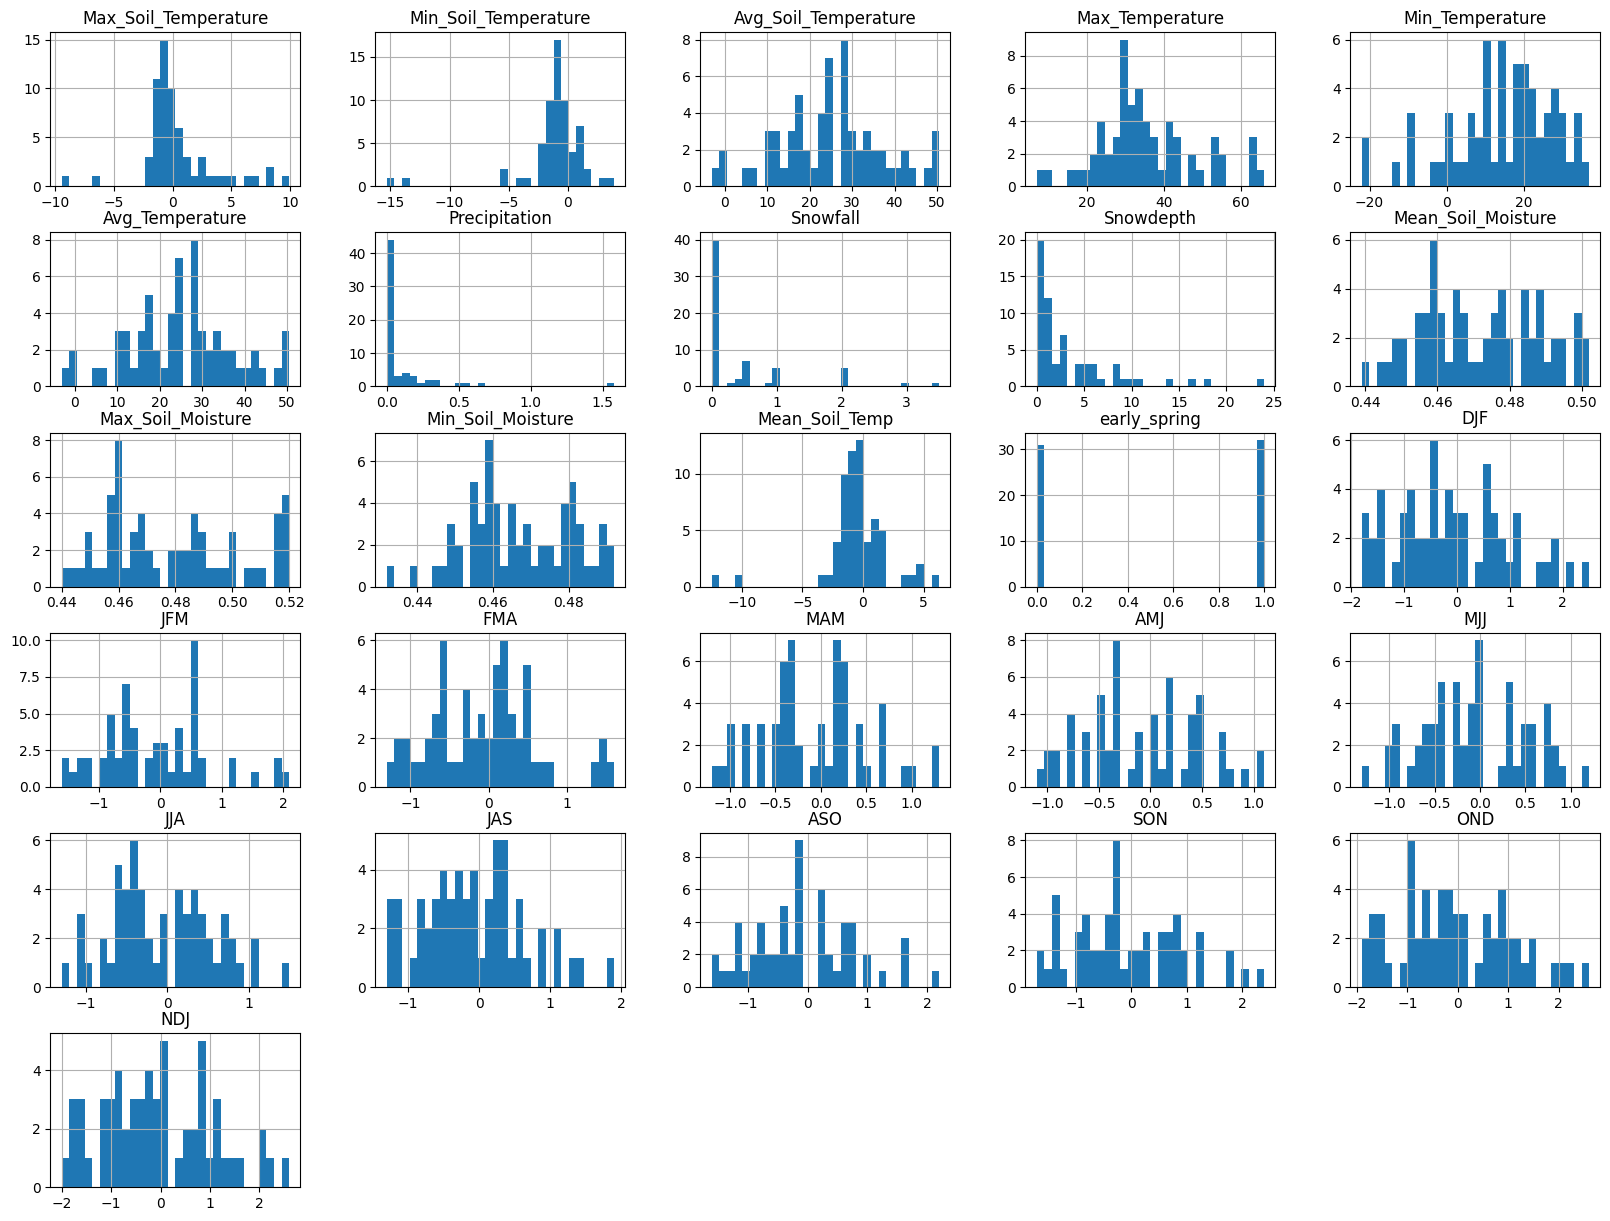

In [50]:
# histrogram of combined data 
combined_data.hist(figsize=(20, 15), bins=30)
plt.show()

| **Feature**         | **Type**       | **% Missing Values**  | **Noisiness (Outliers, Gaps, etc.)** | **Usefulness (Business Goal)**                          | **Distribution**                                          |
|---------------------|----------------|-----------------------|--------------------------------------|---------------------------------------------------------|-----------------------------------------------------------|
| max_temp            | numerical       | 0%                | Outliers detected (5)                | Highly useful (affects early spring)                     | Normal distribution with slight skew                      |
| min_temp            | numerical       | 0%                | Outliers detected (2)                | Highly useful (affects early spring)                     | Normal distribution with slight skew                      |
| avg_temp            | numerical       | 0%                | No outliers detected                 | Highly useful (affects early spring)                     | Normal distribution                                       |
| precipitation       | numerical       | 0%                | Outliers detected (7)                | Somewhat useful (affects snow/soil)                      | Highly skewed (low values dominate) - Log Normal          |
| snowfall            | numerical       | 0%                | Outliers detected (7)                | Important for snow coverage                              | Normal distribution            |
| snowdepth           | numerical       | 1.587302%                | Outliers detected (4)                | Useful (indicates snow cover)                            | Normal Distribution                |
| early_spring        | categorical            | 0%                | No issues detected                   | Target variable                                          | Binary: True/False                                        |
| mean_soil_moisture  | numerical       | 0%                | No outliers detected                 | Useful for predicting soil conditions                    | Skewed, concentrated around a median                      |
| min_soil_temp       | numerical       | 0%                | Outliers detected (8)                | Relevant (affects soil temperature)                      | Skewed, with negative values                              |
| min_soil_moisture   | numerical       | 0%                | No outliers detected                 | Some relevance                                           | Skewed, concentrated in a narrow range                    |
| max_soil_temp       | numerical       | 0%                | Outliers detected (10)               | Relevant for planting decisions                          | Skewed but centered                                       |
| max_soil_moisture   | numerical       | 0%                | No outliers detected                 | Useful for soil moisture trends                          | Right-Skewed Distribution                                 |
| mean_soil_temp       | numerical       | 0%                | Outliers detected (7)               | Relevant for planting decisions                          | Skewed but centered                                       |
| DJF                 | numerical       | 4.761905%                | Outliers detected (0)   | Useful for El Nino changes                               | Slightly skewed, sort of Normal                           |
| JFM             | numerical       | 6.349206%                  | Outliers detected (0)                   | Useful for seasonal analysis (Winter months)             | Normal Distribution                   |
| FMA             | numerical       | 6.349206%                  | Outliers detected (0)                   | Useful for seasonal analysis (spring months)             | Normal Distribution                   |
| MAM             | numerical       | 6.349206%                  | Outliers detected (0)                  | Useful for seasonal analysis (spring months)             | Bimodial distribution                  |
| AMJ             | numerical       | 6.349206%                  | Outliers detected (0)                  | Useful for planting windows (late spring to early summer)| Normal Distribution                 |
| MJJ             | numerical       | 6.349206%                  | Outliers detected (0)                  | Useful for seasonal analysis (Summer months)             | Normal distribution                  |
| JJA             | numerical       | 6.349206%                  | Outliers detected (0)                 | Relevant for summer months                              | Normal distribution              |
| JAS             | numerical       | 6.349206%                  | Outliers detected (0)                 | Useful for late summer and harvesting trends             | Normal distribution                                               |
| ASO             | numerical       | 6.349206%                  | Outliers detected (0)                | Useful for late summer to early fall analysis            | Normal distribution                                |
| SON             | numerical       | 6.349206%                  | Outliers detected (0)                   | Relevant for fall seasons                                | Normal distribution                   |
| OND             | numerical       | 6.349206%                  | Outliers detected (0)                   | Useful for winter changes                                | Normal distribution             |
| NDJ             | numerical       | 6.349206%                  | Outliers detected (0)                   | Relevant for early winter                                | Bimodial distribution                         |


1. **Temperature Features (Max, Min, Avg)**:
   - These temperature features (max, min, and average) are highly useful for predicting early spring as they influence the soil temperature and overall growth conditions.
   - The distributions for these features are generally normal with slight skew, meaning that the majority of values are concentrated around the mean with a few outliers, particularly in extreme weather conditions.
   - No missing values are present, making these features reliable for modeling.

2. **Soil Moisture and Soil Temperature**:
   - These features are crucial for understanding the planting conditions, especially `mean_soil_moisture` and `max_soil_moisture`, which have a skewed but centered distribution. This suggests that soil moisture is consistent in certain ranges but there are outliers that may impact planting.
   - `max_soil_temp` and `min_soil_temp` are also essential as they affect planting decisions directly by indicating optimal growing conditions.
   - The distribution shows a skew towards certain values, indicating variability in soil moisture and temperature across the dataset, but no significant gaps or missing values were detected.

3. **Seasonal Features (FMA, MAM, etc.)**:
   - These features represent important seasonal trends for various months and combinations of months (e.g., FMA for February-March-April).
   - They are generally normally distributed with minor outliers, which is expected given seasonal temperature variations.
   - The usefulness of these features comes from their relevance to key planting and growing seasons, particularly spring and early summer, which influence the early spring predictions.

4. **Precipitation and Snowfall**:
   - These features are skewed, with precipitation and snowfall having highly skewed log-normal distributions. The majority of the values are low, but there are a few extreme cases.
   - Despite this skew, these features are still somewhat useful for understanding snow/soil dynamics, which indirectly affect early spring predictions.
   - These variables have no missing values, but the outliers may need further exploration to understand their impact on the model.

5. **DJF (December, January, February)**:
   - The `DJF` feature is used for analyzing El Nino and winter season changes. It shows some gaps and a slightly skewed distribution.
   - The feature could provide insights into the influence of winter temperature trends on the onset of early spring, particularly in extreme conditions like El Nino years.

6. **Early Spring**:
   - This is the target variable and has no missing values or issues detected. It is binary (True/False), which makes it ideal for classification tasks.
   - The overall model should focus on correlating other features to this target variable to make accurate predictions about early spring.

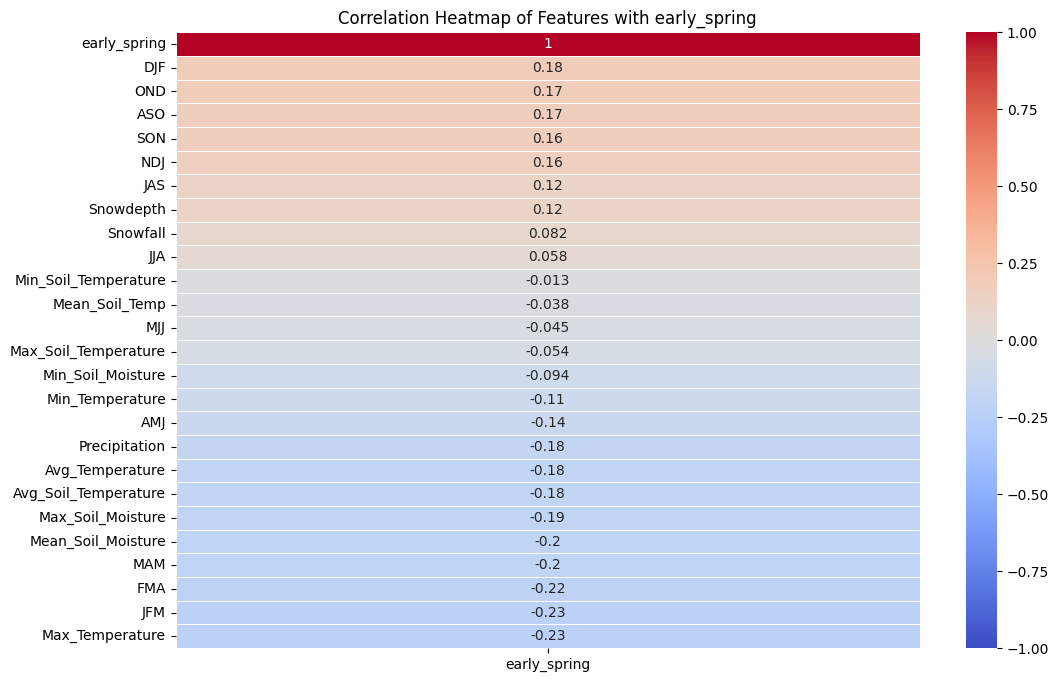

In [51]:
correlation_matrix = combined_data.corr()

# Set the figure size for better readability
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix[['early_spring']].sort_values(by='early_spring', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Features with early_spring')
plt.show()

- **DJF** (December-January-February temperatures) has the highest positive correlation with `early_spring` (0.18). This suggests that winter temperatures may have a significant impact on predicting early spring, likely because warmer winters lead to earlier spring conditions.

- **OND, ASO, SON, and NDJ** also show moderate positive correlations (between 0.12 to 0.18) with `early_spring`. These months represent fall and early winter, indicating that seasonal transition periods may influence early spring conditions.

- **JFM, FMA, and MAM** have a strong negative correlation with `early_spring` (between -0.2 to -0.23). These months represent from winter to spring, showcasing that these transitions have a influence to the target label.

- **Snow-related features**:
  - **Snowdepth** and **Snowfall** have weaker correlations with `early_spring` (0.058 and 0.082, respectively). This suggests that while snow features are relevant, they may not be as predictive as temperature variables.

- **Soil Temperature and Moisture**:
  - The **Min, Max, and Avg Soil Temperatures** have negative correlations with `early_spring`. The correlation is from -0.18 to -0.2, and this could have some sort of influence to the target label as well. 
  - **Soil Moisture** (min) also shows weak correlation, with no strong predictive influence over early spring.

- **Precipitation and Temperature**:
  - **Precipitation** and **Temperature** (Max, Min, Avg) show small negative correlations with `early_spring`, with the highest being -0.23. These results suggest that precipitation and general temperature trends during the year may have some inverse relationship with early spring predictions, but they are not strong indicators in isolation.

### Key Takeaways:
1. **DJF and Fall/Winter Periods** have the most positive correlations with `early_spring`, indicating that winter temperatures play a significant role in early spring predictions.
2. **Snow Features** have weak correlations, suggesting their impact on predicting early spring is minor compared to temperature.
3. **Soil Temperature and Moisture** have a strong negative correlationi, suggesting that soil temperature and moisture have some indication towards an early spring, but not as heavy as some soil and moisture features also lie with a weak correlation as well. 

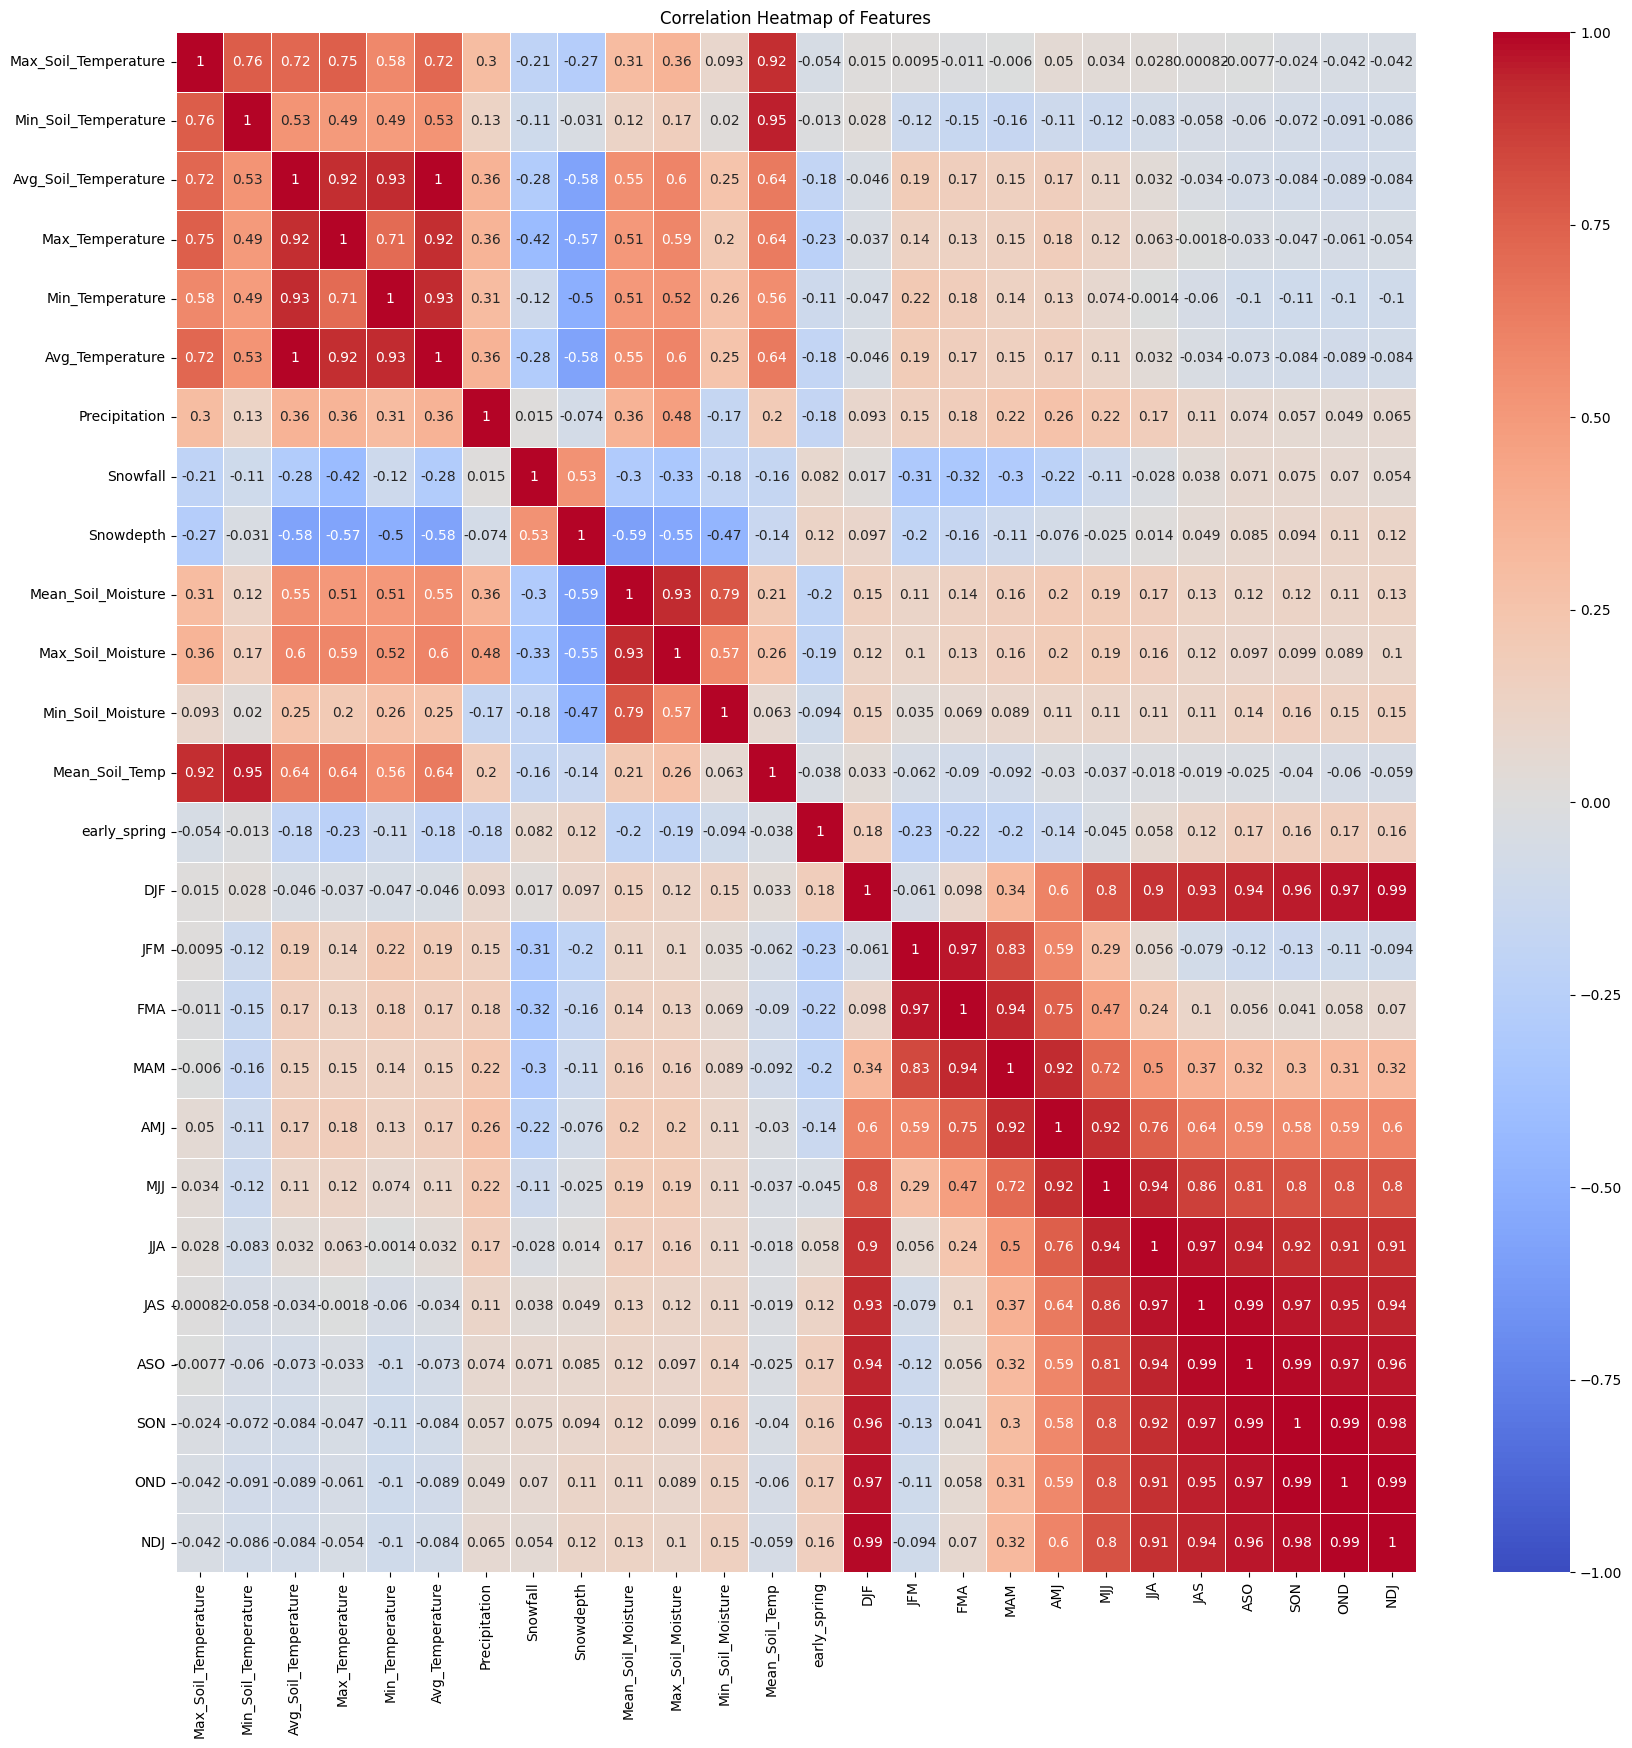

In [52]:
# feature correlations heat map 
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

1. **Strong Correlation Between Temperature Features**:
   - `Max_Soil_Temperature`, `Min_Soil_Temperature`, `Avg_Soil_Temperature`, `Max_Temperature`, `Min_Temperature`, and `Avg_Temperature` are highly correlated with each other (values around 0.93–1.00).
   - This suggests that these temperature features are interrelated, and including all of them in the model might lead to redundancy. Dimensionality reduction techniques (like PCA) or feature selection could be useful to avoid multicollinearity.

2. **Correlation with Early Spring**:
   - `Snowdepth` shows a negative correlation (-0.19) with `early_spring`, indicating that lower snow depth might be associated with the early onset of spring.
   - `Precipitation` has a moderate negative correlation (-0.18) with `early_spring`, suggesting that lower precipitation might be a factor in predicting early spring.
   - Temperature features such as `Max_Soil_Temperature`, `Min_Soil_Temperature`, and `Avg_Soil_Temperature` show correlations with `early_spring`, with values around 0.13–0.18, indicating their importance but not as primary predictors.

3. **Snowfall and Soil Moisture Relationships**:
   - `Snowfall` is negatively correlated with `Soil_Temperature` features and `Snowdepth`, as expected. More snowfall tends to lead to higher snow depth, which impacts soil temperature.
   - `Snowfall` also shows a negative correlation (-0.55) with `Snowdepth`, and this relationship is important in understanding how snow coverage influences soil conditions.

4. **Seasonal Features (DJF, FMA, etc.)**:
   - The seasonal features (DJF, JFM, FMA, etc.) are highly correlated with each other, which is natural because they represent overlapping time periods (like December-February, January-March).
   - `DJF` and similar features show correlations with `early_spring`, with values ranging from 0.1 to 0.18. These features could be significant for modeling early spring, but the influence of seasonal temperature may need further exploration.

5. **Soil Moisture**:
   - `Mean_Soil_Moisture`, `Max_Soil_Moisture`, and `Min_Soil_Moisture` show correlations with `early_spring`, indicating that moisture levels may not have a strong direct impact on early spring predictions.
   - However, these features still hold relevance, especially when combined with other environmental conditions like temperature and snow depth.

### Key Insights:
- **Temperature features** are highly correlated with each other but only show direct correlations with `early_spring`. These features may still play a role in modeling but could be redundant.
- **Precipitation and snow-related features** like `Snowfall` and `Snowdepth` have to moderate negative correlations with `early_spring`, meaning they could be useful for predictions but are not dominant factors.
- **Seasonal indicators** show correlations with `early_spring`, but their combination with other features like soil temperature and snow conditions could improve model performance.

### Next Steps:
- Consider reducing dimensionality for highly correlated temperature features to avoid overfitting.
- Focus on interactions between precipitation, snow, and soil temperature to model early spring more effectively.

<Figure size 2000x2000 with 0 Axes>

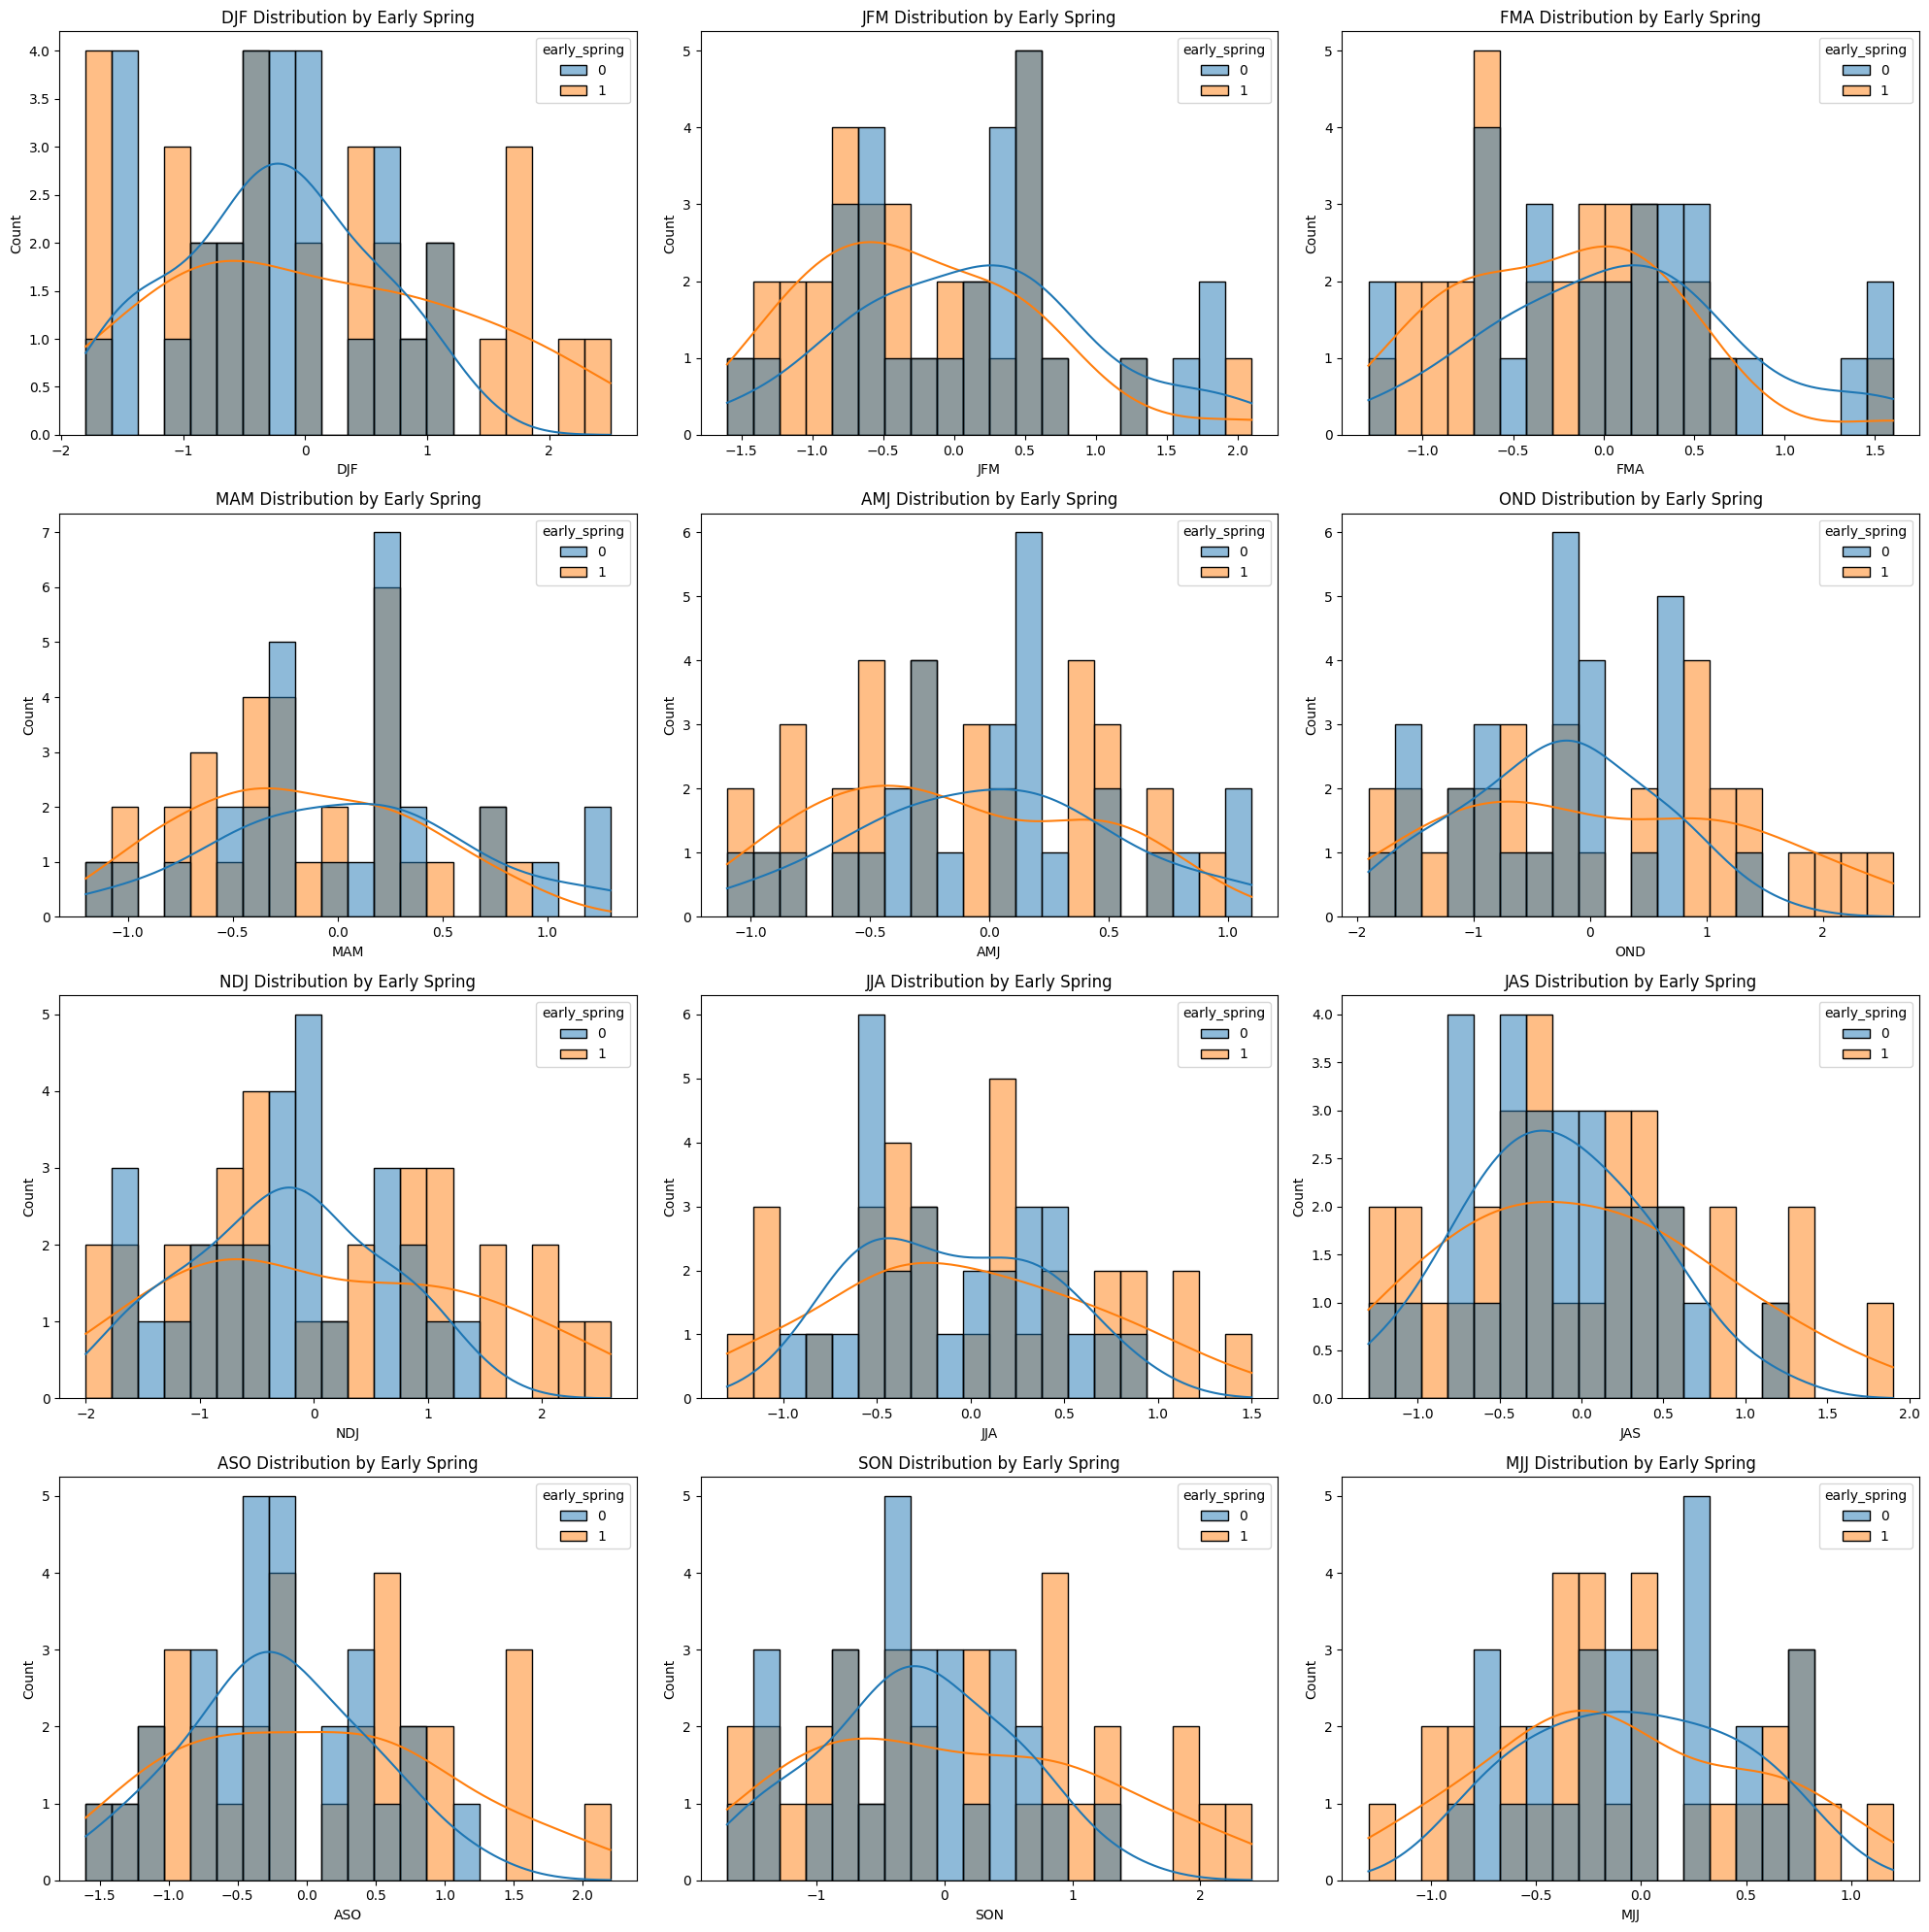

In [53]:
plt.figure(figsize=(20, 20))

# Create a 4x4 grid of histograms
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.flatten()

# Plot histograms for seasonal features and compare with early_spring as hue
seasonal_features = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'OND', 'NDJ', 'JJA', 'JAS', 'ASO', 'SON', 'MJJ']
for i, feature in enumerate(seasonal_features):
    sns.histplot(data=combined_data, x=feature, hue='early_spring', kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Early Spring')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Seasonal Features with Early Spring:

1. **DJF (December-January-February) Distribution:**
   - The early_spring occurrences (orange hue) show a broad distribution across DJF values, with a slight peak in the positive range of the DJF feature. This indicates that higher DJF values slightly increase the likelihood of early spring.

2. **JFM (January-February-March) Distribution:**
   - Both early_spring and non-early_spring values are distributed relatively evenly across the JFM feature. The overlap suggests that JFM may not be a highly discriminative feature for predicting early spring.

3. **FMA (February-March-April) Distribution:**
   - Early spring is more frequent for higher FMA values, whereas lower values correspond more to non-early_spring. This indicates a positive association between higher FMA values and the likelihood of early spring.

4. **MAM (March-April-May) Distribution:**
   - The feature displays a more spread distribution for both early_spring and non-early_spring, showing some indication that higher MAM values might have more early_spring occurrences.

5. **AMJ (April-May-June) Distribution:**
   - Similar to MAM, the spread of early_spring occurrences shows a wider distribution, suggesting that AMJ is not highly predictive of early spring but still worth considering in relation to other features.

6. **OND (October-November-December) Distribution:**
   - OND seems to show an even distribution across early_spring and non-early_spring values, indicating it may not be a strong feature for discriminating between early spring and non-early spring years.

7. **NDJ, JJA, JAS, ASO, SON, MJJ Distributions:**
   - These features show mixed results, with no particularly strong trends emerging in relation to early_spring occurrences. Most of these months appear to have a mix of early_spring and non-early_spring occurrences without a clear separation in their distributions.

### Summary:
- **FMA** and **DJF** show more promise as useful seasonal indicators for early spring occurrences, with FMA showing a positive association with early spring.
- Other seasonal features such as **JFM**, **MAM**, and **AMJ** show some spread but are less distinct in predicting early spring occurrences.


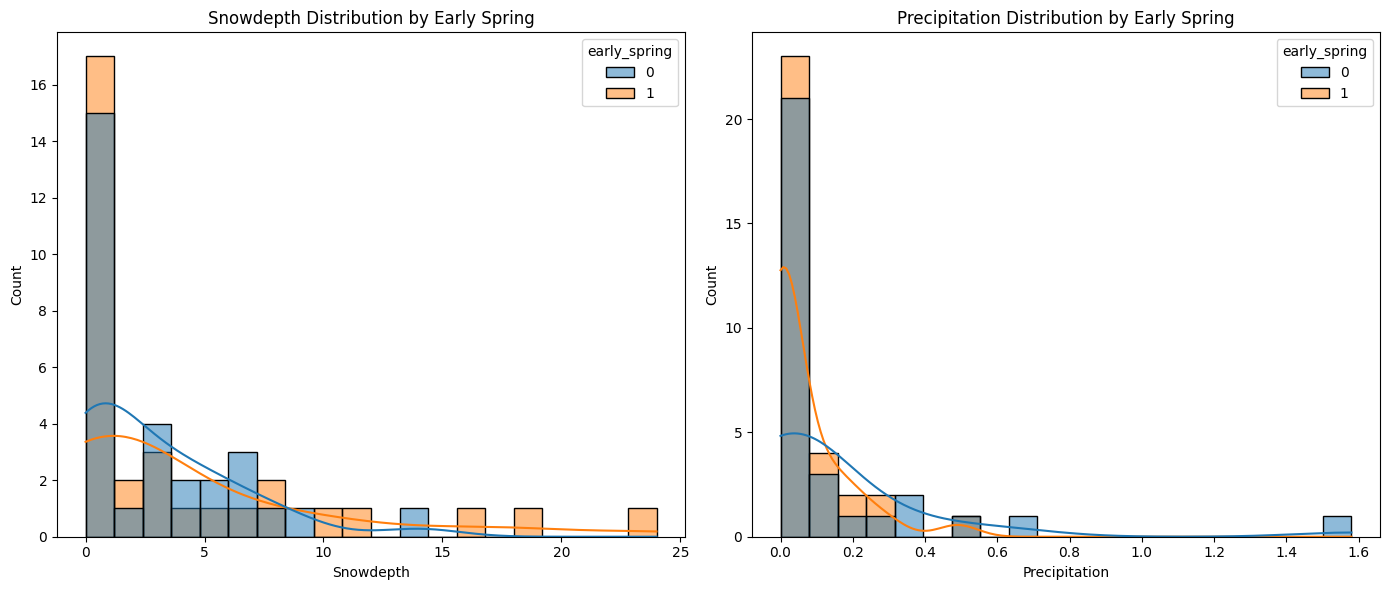

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Snowdepth Distribution by Early Spring
sns.histplot(data=combined_data, x='Snowdepth', hue='early_spring', kde=True, bins=20, ax=axes[0])
axes[0].set_title('Snowdepth Distribution by Early Spring')
axes[0].set_xlabel('Snowdepth')
axes[0].set_ylabel('Count')

# Plot Precipitation Distribution by Early Spring
sns.histplot(data=combined_data, x='Precipitation', hue='early_spring', kde=True, bins=20, ax=axes[1])
axes[1].set_title('Precipitation Distribution by Early Spring')
axes[1].set_xlabel('Precipitation')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Snowdepth and Precipitation
Both features (snow depth and precipitation) exhibit weak relationships with early_spring, as indicated by their distributions. The bulk of both distributions cluster around low values (0), and while there are some slight trends, they are not strong predictors on their own. Further exploration in combination with other variables might reveal more significant insights.

### Feature Importances (Random Forest):

In [55]:
feature_importances_df

,feature,importance
371,mean_soil_temp_36,0.013644
52,max_temp_53,0.011507
388,mean_soil_temp_53,0.011100
282,snowdepth_3,0.010803
539,min_soil_moisture_36,0.009819
...,...,...
366,mean_soil_temp_31,0.000000
99,min_temp_44,0.000000
100,min_temp_45,0.000000
101,min_temp_46,0.000000


In [56]:
train_data

,max_temp_1,max_temp_2,max_temp_3,max_temp_4,max_temp_5,max_temp_6,max_temp_7,max_temp_8,max_temp_9,max_temp_10,max_temp_11,max_temp_12,max_temp_13,max_temp_14,max_temp_15,max_temp_16,max_temp_17,max_temp_18,max_temp_19,max_temp_20,max_temp_21,max_temp_22,max_temp_23,max_temp_24,max_temp_25,max_temp_26,max_temp_27,max_temp_28,max_temp_29,max_temp_30,max_temp_31,max_temp_32,max_temp_33,max_temp_34,max_temp_35,max_temp_36,max_temp_37,max_temp_38,max_temp_39,max_temp_40,max_temp_41,max_temp_42,max_temp_43,max_temp_44,max_temp_45,max_temp_46,max_temp_47,max_temp_48,max_temp_49,max_temp_50,max_temp_51,max_temp_52,max_temp_53,max_temp_54,max_temp_55,max_temp_56,min_temp_1,min_temp_2,min_temp_3,min_temp_4,min_temp_5,min_temp_6,min_temp_7,min_temp_8,min_temp_9,min_temp_10,min_temp_11,min_temp_12,min_temp_13,min_temp_14,min_temp_15,min_temp_16,min_temp_17,min_temp_18,min_temp_19,min_temp_20,min_temp_21,min_temp_22,min_temp_23,min_temp_24,min_temp_25,min_temp_26,min_temp_27,min_temp_28,min_temp_29,min_temp_30,min_temp_31,min_temp_32,min_temp_33,min_temp_34,min_temp_35,min_temp_36,min_temp_37,min_temp_38,min_temp_39,min_temp_40,min_temp_41,min_temp_42,min_temp_43,min_temp_44,min_temp_45,min_temp_46,min_temp_47,min_temp_48,min_temp_49,min_temp_50,min_temp_51,min_temp_52,min_temp_53,min_temp_54,min_temp_55,min_temp_56,avg_temp_1,avg_temp_2,avg_temp_3,avg_temp_4,avg_temp_5,avg_temp_6,avg_temp_7,avg_temp_8,avg_temp_9,avg_temp_10,avg_temp_11,avg_temp_12,avg_temp_13,avg_temp_14,avg_temp_15,avg_temp_16,avg_temp_17,avg_temp_18,avg_temp_19,avg_temp_20,avg_temp_21,avg_temp_22,avg_temp_23,avg_temp_24,avg_temp_25,avg_temp_26,avg_temp_27,avg_temp_28,avg_temp_29,avg_temp_30,avg_temp_31,avg_temp_32,avg_temp_33,avg_temp_34,avg_temp_35,avg_temp_36,avg_temp_37,avg_temp_38,avg_temp_39,avg_temp_40,avg_temp_41,avg_temp_42,avg_temp_43,avg_temp_44,avg_temp_45,avg_temp_46,avg_temp_47,avg_temp_48,avg_temp_49,avg_temp_50,avg_temp_51,avg_temp_52,avg_temp_53,avg_temp_54,avg_temp_55,avg_temp_56,precipitation_1,precipitation_2,precipitation_3,precipitation_4,precipitation_5,precipitation_6,precipitation_7,precipitation_8,precipitation_9,precipitation_10,precipitation_11,precipitation_12,precipitation_13,precipitation_14,precipitation_15,precipitation_16,precipitation_17,precipitation_18,precipitation_19,precipitation_20,precipitation_21,precipitation_22,precipitation_23,precipitation_24,precipitation_25,precipitation_26,precipitation_27,precipitation_28,precipitation_29,precipitation_30,precipitation_31,precipitation_32,precipitation_33,precipitation_34,precipitation_35,precipitation_36,precipitation_37,precipitation_38,precipitation_39,precipitation_40,precipitation_41,precipitation_42,precipitation_43,precipitation_44,precipitation_45,precipitation_46,precipitation_47,precipitation_48,precipitation_49,precipitation_50,precipitation_51,precipitation_52,precipitation_53,precipitation_54,precipitation_55,precipitation_56,snowfall_1,snowfall_2,snowfall_3,snowfall_4,snowfall_5,snowfall_6,snowfall_7,snowfall_8,snowfall_9,snowfall_10,snowfall_11,snowfall_12,snowfall_13,snowfall_14,snowfall_15,snowfall_16,snowfall_17,snowfall_18,snowfall_19,snowfall_20,snowfall_21,snowfall_22,snowfall_23,snowfall_24,snowfall_25,snowfall_26,snowfall_27,snowfall_28,snowfall_29,snowfall_30,snowfall_31,snowfall_32,snowfall_33,snowfall_34,snowfall_35,snowfall_36,snowfall_37,snowfall_38,snowfall_39,snowfall_40,snowfall_41,snowfall_42,snowfall_43,snowfall_44,snowfall_45,snowfall_46,snowfall_47,snowfall_48,snowfall_49,snowfall_50,snowfall_51,snowfall_52,snowfall_53,snowfall_54,snowfall_55,snowfall_56,snowdepth_1,snowdepth_2,snowdepth_3,snowdepth_4,snowdepth_5,snowdepth_6,snowdepth_7,snowdepth_8,snowdepth_9,snowdepth_10,snowdepth_11,snowdepth_12,snowdepth_13,snowdepth_14,snowdepth_15,snowdepth_16,snowdepth_17,snowdepth_18,snowdepth_19,snowdepth_20,snowdepth_21,snowdepth_22,snowdepth_23,snowdepth_24,snowdepth_25,snowdepth_26,snowdepth_27,snowdepth_28,snowdepth_29,snowdepth_30,snowdepth_31,snowdepth_